In [49]:
import numpy as np
import tensorflow as tf
import json
from datetime import datetime
import os
import sys
sys.path.append('../')
import retriever
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
trainset_file = '../data/training/order_train_data.bin'
testset_file = '../data/training/order_test_data.bin'
vocab_file =  '../data/metadata/w2v_vocab.json'
params_dir_tmp = '../data/training/models/All/'
embed_path =  '../data/metadata/w2v.bin'

<h3>Each entry in this list has the following structure:</h3>
<ul>
<li>entry[0]: query indexes </li>
<li>entry[1:n]: n items where each item is [bounding box vector, bounding box spaital features]. Note that different enteries might have different 'n' </li>
<li>entry[n+1]: integer, entry[ 1 + entry[n+1]] is the ture bbox </li>
</ul>

In [3]:
trainset = np.load(open(trainset_file, 'rb'))
trainset = [item for item in trainset if len(item)>2 and len(item[0])>0]
print('trainset barches #:', len(trainset))

testset = np.load(open(testset_file, 'rb'))
testset = [item for item in testset if len(item)>2 and len(item[0])>0]
print('test barches #:', len(testset))

with open(vocab_file, 'r') as f:
    vocab = json.loads(f.read())

trainset barches #: 297
test barches #: 297


In [4]:
vocab['<unk>'] = len(vocab)

In [5]:
embed_vecs = np.load(open(embed_path, 'rb')).astype(np.float32)

<h3> augment_data function </h3>
<br>We try sevral regularization methods. One of the things I've tried is to add data points where for each data I pick a query from a random data point and a set of bbox from a different random point. We build the labels (bboxes) distribution by giving an equal probability to each label. <br><br>
The augment_data function does just that but the label of each added poind is writen as -1*number of bboxes. When we build the batch it self (function build_data in class Model), if we see a negative label index, we know its an added point and we know the number of bboxes so we can build the correct distribution.  

In [6]:
def augment_data(data, ratio=0.5, addNoise=False):
        '''
        The function add data points. 
        We pick a query from a random data point,
        and a set of bbox from a different random point and we join them
        to build a new data point. The label distribution of the new data point will 
        uniform, that is, all labels will have equal probability. 
        
        
        Params:
            data: a list of data entries
                                                
        Returns: a list of augmented data
            
                        
        '''
                          
        q_idx = np.random.choice(range(len(data)), int(len(data)*ratio), replace=False)
        im_idx = np.random.choice([i for i in range(len(data)) if i not in q_idx], int(len(data)*ratio))
        for i in range(len(q_idx)):
            q, im = data[q_idx[i]][0], data[im_idx[i]][1:-1]
            item = [q]
            for im_tmp in im:
                item.append(im_tmp)
            item.append(-len(im))
            data.append(item)

# ALSTM

This RNN cell has two LSTM cells, Bcell (for player B) and Acell (for Player A) and work as follow:
<ol> 
<li>We run B's cells with the true query input word, getting the un-edited state. If use_worsAttn=True we add attention on the images vectors for each word.</li>
<li>We run B's cells with the edited input word - 'unk', getting the edited state. If use_worsAttn=True we add attention on the images vectors for each word.</li>
<li>We feed the un-edited state to A's cell.</li>
<li>We run A's cells. A's input are:
<ul><li>B's un-edited state</li><li>The reward for editing a word</li><li>B's loss having no edited words.</li></ul></li>
<li>A's output is then goes throw a transformation which yields two values, one for editing a word and another for not.<br>If the the value for edit the word is higher, we pass B's edited state to the next time step, else we pass B's un_edit state.</li><br>
</ol>

In [7]:
class ALSTM(tf.nn.rnn_cell.LSTMCell):
    def __init__(self, 
                 batch_size, 
                 num_units, 
                 
                 # Size of A's attention vector.
                 words_attn_dim, 
                 # B's outputs (for each time step).
                 words_attn_states, 
                 # Inicates whether attentionvec is a padding (0) or not (1).
                 words_attn_idx, 
                 
                 # Size of B's attention vector ([image vector, spital features] size) .
                 img_attn_dim, 
                 # B's outputs (for each time step).
                 img_attn_states, 
                 
                 
                 # Inicates whether attentionvec is a padding (0) or not (1).
                 img_attn_idx, 
                 
                 unk, #'unk' word vector
                 
                 # Probabilty for edit a word in rnn, 
                 # when decision are taken randomly.
                 rnn_editProb, 
                 
                 
                 # Whehter to edit the query or not.
                 isEdit, 
                 
                 # Whether B uses words levlel attention or not.
                 use_wordAttn,
                 
                 # If True add noise instead of using 'unk'
                 useNoise=False,
                 
                 # If useNoise is true word vec = alpha*word_vector+(1-alpha)*noise
                 alpha=.3,
                 
                 # when isEdit=True, whether or not to use A's 
                 # output inorder to edit or to do it randomly.
                 activateA=False,
                 
                 #this holds A's rewards and B's losses to
                 # be add to A's feature vectors.
                 reward_loss=None,
                 state_is_tuple=True,):
        
        
        # When useing A, the cell state will contain the concatenation 
        # of both B and A states. Therefore we set the unit number to be
        # 2*(A and B unit size).
        super().__init__(2*num_units, state_is_tuple=state_is_tuple)
    
        self.words_attn_states = words_attn_states
        self.words_attn_idx = words_attn_idx
        self.words_attn_dim = words_attn_dim
        
        self.img_attn_states = img_attn_states
        self.img_attn_idx = img_attn_idx
        self.img_attn_dim = img_attn_dim
        
        self.num_units = num_units
        self.batch_size = batch_size
        self.unk = unk 
        self.isEdit = isEdit
        self.activateA = activateA
        self.use_wordAttn=use_wordAttn
        
        
        self.Acell = tf.nn.rnn_cell.LSTMCell(self.num_units, state_is_tuple=True)
        self.Bcell = tf.nn.rnn_cell.LSTMCell(self.num_units, state_is_tuple=True)
        
        self.rnn_editProb = rnn_editProb
        self.reward_loss = reward_loss
        self.useNoise=useNoise
        self.alpha=alpha
        

    def call(self, inputs, state):
        '''
        Params:
            inputs: word embadding.
            state:  [B's state form privious state, A's state form privious state]
        '''
        # takse B's state from state[:self.num_units]
        Bstate_c = tf.slice(state[0], [0, 0], [-1, self.num_units])
        Bstate_h = tf.slice(state[1], [0, 0], [-1, self.num_units])
        self.Bstate =  tf.nn.rnn_cell.LSTMStateTuple(c=Bstate_c, h=Bstate_h)
         
        # If B's cell uses attention
        if self.use_wordAttn:
            words_attn = self.attention(Bstate_h, self.img_attn_states, self.img_attn_dim, self.img_attn_idx)
            new_input = tf.concat([inputs, words_attn], -1)
            Boutputs, Bnew_state =  self.Bcell(new_input, self.Bstate, 'Bcell')
        else:
            Boutputs, Bnew_state =  self.Bcell(inputs, self.Bstate, 'Bcell')

        
        # If isEdit==True 
        def f1(): 
            # takse A's state from state[self.num_units: 2*self.num_units]
            Astate_c = tf.slice(state[0], [0, self.num_units], [-1, self.num_units])
            Astate_h = tf.slice(state[1], [0, self.num_units], [-1, self.num_units])
            self.Astate =  tf.nn.rnn_cell.LSTMStateTuple(c=Astate_c, h=Astate_h)
            
            if self.useNoise: # just add noise to the edited words
                new_unk_vecs = self.alpha*inputs + (1-alpha)*tf.random_normal(shape=inputs.get_shape(), stddev=0.1)
            else: # change the edited words by 'unk'
                unk_vecs = tf.concat([self.unk for _ in range(self.batch_size)], 0) # shape: self.batch_size x 1 x embed_size
                new_unk_vecs = tf.squeeze(unk_vecs) # shape: self.batch_size x embed_size
            
            # run B's cell with unk_batch
            if self.use_wordAttn:
                new_unk = tf.concat([new_unk_vecs, words_attn], -1)
            else:
                new_unk = new_unk_vecs
            edit_output, edit_new_state = self.Bcell(new_unk, self.Bstate, 'Bcell')  
            out1, state1 = self.runCell(Boutputs, Bnew_state, edit_new_state)
            return out1, state1
        
        def f2(): 
            outs = tf.concat([Boutputs, tf.zeros((self.batch_size, self.num_units))], 1)
            new_state_c = tf.concat([Bnew_state[0], tf.zeros_like(Bnew_state[0])], 1)
            new_state_h = tf.concat([Bnew_state[1], tf.zeros_like(Bnew_state[1])], 1)
            return outs, tf.nn.rnn_cell.LSTMStateTuple(c=new_state_c, h=new_state_h)
        
        new_output, new_state = tf.cond(self.isEdit, f1, f2)
        
        return new_output, new_state
    
    def runCell(self, Boutputs, Bnew_state, edit_new_state):
        '''
        Run B's cell after editing.
        
        params:
            Boutputs: output vector without editing.
            Bnew_state: state vector without editing.
            edit_new_state: state vector after editing the input word to 'unk'. 
        '''
        
        with tf.variable_scope('runcell'):
            # get action values according to B's hidden state
            Aout, Anew_state, actions_vals = self.action_vals(Boutputs) 
            
            def f1(): 
                '''
                If self.activateA==True, edit word if actions_vals[0]<actions_vals[1].
                Note: if we edit the word cond=1, else cond=0.
                '''
                a1, a2 = tf.split(value=actions_vals, num_or_size_splits=2, axis=1)
                cond = tf.less(a1, a2)
                return cond

            def f2(): 
                '''
                If self.activateA==False, choose randomly whether to edit a word.
                We edit a word with 'rnn_editProb' probability (~U[0,1]).
                Note: if we edit the word cond=1, else cond=0.
                '''
                rand = tf.multinomial(tf.log([[self.rnn_editProb, 1-self.rnn_editProb]]), self.batch_size)
                cond = tf.less(tf.transpose(rand), 1) 
                return cond

            # a list of A's decisions for each batch.  1->edit, 0-> do not edit.
            cond = tf.cast(tf.cond(self.activateA, f1, f2), tf.float32)

            # We'd like to know the action values and decision for each word,
            # therefore theses info are placed on the first 3 dimensions of the 
            # output vector. Note that this vector is not passed to the 
            # next tiee step so it won't affect the model. 
            outs = tf.concat([actions_vals, cond], 1)

            # B's i state is replaced by the edited state if cond[i]=1 (i =1, 2, ..., batch_size)
            new_edit_state_c = (1-cond)*Bnew_state[0] + cond*edit_new_state[0]
            new_edit_state_h = (1-cond)*Bnew_state[1] + cond*edit_new_state[1]


            new_outs = tf.concat([outs, tf.zeros((self.batch_size, 2*self.num_units-3))], 1)
            new_state_c = tf.concat([new_edit_state_c, Anew_state[0]], 1)
            new_state_h = tf.concat([new_edit_state_h, Anew_state[1]], 1)
            return new_outs, tf.nn.rnn_cell.LSTMStateTuple(c=new_state_c, h=new_state_h)
    
    
    def action_vals(self, Boutputs):
        '''
        Get values for editing/not editing the input word.
        
        Params:
            Boutputs: output vector without editing.
            
        Returns vals where:
            Aout: A's cell output
            Anew_state: A's cell state
            vals: Tensor where vals[0] is the value for not editing the word 
                    and vals[1] is the value for editing the word.
        '''
        
        with tf.variable_scope('action_vals') as scope:
            Aattn = self.attention(self.Astate[1], self.words_attn_states, self.words_attn_dim, self.words_attn_idx)
            
            # A's input: [input, B's output, attntion state, reward, B's loss with no edits]
            Anew_inputs = tf.concat([Boutputs, Aattn, self.reward_loss], 1)
            
            Aout, Anew_state = self.Acell(Anew_inputs, self.Astate, 'Acell')
            vals = tf.nn.relu(self.linear(Aout, 2))

            # Save the variables that only A uses. 
            # These variables will be trained separately from B's model.
            self.Avars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope.name)
            
            return Aout, Anew_state, vals
            
        
    def linear(self, inputs, output_dim, scope='linear', bias=True, reuse=False):
        with tf.variable_scope(scope, reuse=False):
            W = tf.get_variable('W', initializer=tf.random_uniform_initializer(maxval=1., minval=-1.),
                                shape=(inputs.get_shape()[-1], output_dim))
            if bias:
                b = tf.get_variable('b', initializer=tf.constant_initializer(0.1),
                               shape=[1, output_dim])
                return tf.matmul(inputs, W) + b

        return tf.matmul(inputs, W)
    
    
    def attention(self, state, attn_states, attn_dim, attn_idx, relu=False):
        '''
        Attention mechanism (see https://arxiv.org/pdf/1409.0473.pdf)
        
        state: State from previous time step.
        attn_states: Attetntion states. 
                     Tensor of shape (batch_size x max([len(attention_vectors[i]) for i in range(bach_size)]) x attn_dim)
        attn_dim: Attention vector size.
        attn_idx,: Tensor used for masking of shape (batch_size x max([len(attention_vectors[i]) for i in range(bach_size)]). 
                   attn_idx[i, j]=1 if the j's attention vcctior of sample i  is not padding, else its equat to 0.
        '''
        
        self.attn_length = tf.shape(attn_states)[1]  
        
        # Computing... hidden_attn = W*v_att (use tf.nn.conv2d for efficiency)
        attn_vecs = tf.reshape(attn_states, [self.batch_size, self.attn_length, 1, attn_dim])
        W = tf.get_variable("attn_W", [1, 1, attn_dim, self.num_units])
        hidden_attn = tf.nn.conv2d(attn_vecs, W, [1, 1, 1, 1], "SAME")

        # Computing... hidden_s = U*v_state
        hidden_s = tf.reshape(
            self.linear(
                tf.cast(state, tf.float32), output_dim=self.num_units, scope='hidden_s_linear'), [-1, 1, 1,  self.num_units], name='hidden_s')

        # Computing alpha
        v = tf.get_variable("attn_v", [self.num_units])
        if relu:
            logits = tf.reduce_sum(v * tf.nn.relu(hidden_attn + hidden_s), [2, 3])
        else:
            logits = tf.reduce_sum(v * tf.nn.tanh(hidden_attn + hidden_s), [2, 3])

        # Masked softmax
        max_logits = tf.reduce_max(logits, axis=-1)
        masked_logits = tf.exp(logits-tf.expand_dims(max_logits, axis=1))*attn_idx
        alpha = masked_logits/tf.reduce_sum(masked_logits, axis=-1, keep_dims=True)

        a = tf.reduce_sum(tf.reshape(alpha, [-1, self.attn_length, 1, 1]) * attn_vecs, [1, 2])
        b = tf.contrib.layers.fully_connected(a, num_outputs=self.num_units, 
                                                normalizer_fn=tf.contrib.layers.batch_norm, scope='proj')

        return b

# Training
When A joins the game, each iteration is completed via three steps:
<ul>
<li>We feed the query as it is to B and run it alone (no optimization nor training is done in this step)</li>
<li>We run A and B together (no optimization nor training is done in this step). At this step we get A's decition and B's loss on the edited query. We use B's loss to calculate the Bellman's value for each time step. </li>
<li>We again run A and B together, since now we know the real values for each time step and the real action for each time step (these will be the same as in the previous step since we did not train optimize the parameters yet), we finaly train the model</li>
</ul>
<br>
But first we check the model's performance with out A. Class Model has a set of conditioning variables that set a different ragularization methods in the model. We start by checking them with out A's interference. We can also make the model RNN become bidirectional (by setting useBidirectionalRnn to True) and use words level attention (by setting use_wordAttn to True).

In [32]:
class Model():
    def __init__(self,
                 batch_size, 
                 num_hidden, 
                 
                 #Image's vector size.
                 img_dims, 
                 
                 #Spaital features length.
                 bbox_dims, 
                 
                 #Probabilty for edit a word in rnn, when decision are taken randomly.
                 rnn_editProb,  
                 vocab, 
                 lr, #  B's learning rate.
                 decay_steps, 
                 decay_rate, 
                 
                # coefficient to multiply the reward by when editing a word.
                 edit_reward,
                 
                 # A's leanring rate = B's learning rate x coefAlr.
                 coefAlr,
                 
                 # whether to use bach normaliztion for the last attention layer
                 bnorm,
                 embed_size=embed_vecs.shape[1],
                 # Whether B uses words levlel attention or not.
                 use_wordAttn=False,
                 
                 # Whther to use bidirectional rnn
                 useBidirectionalRnn=False):
        
        self.batch_size = batch_size
        self.img_dims = img_dims
        self.bbox_dims = bbox_dims 
        self.num_hidden = num_hidden
        self.embed_size = embed_size
        self.vocab = vocab
        L2Reg = 0.0005 # L2 regulizerr coefficient
        self.lr = lr


        self.queries = tf.placeholder(tf.int32, [None, None], name='queries')
        self.img  = tf.placeholder(tf.float32, [None, None, self.img_dims], name='img')# VGG output vectors
        self.bboxes = tf.placeholder(tf.float32, [None, None, self.bbox_dims], name='bboxes')# spatial bbox's features.
        
        # attn_idx: inicates whether attention box is a dummy (0) or not (1).
        self.attn_idx = tf.placeholder(tf.float32, [None, None], name='attn_idx')
        
        self.labels = tf.placeholder(tf.float32, [None, None], name='labels')
        self.isEdit = tf.placeholder(tf.bool, name='isEdit') # whehter to edit the query or not.
        
        # when isEdit=True, whether to use A's output in order to edit or to do it randomly.
        self.activateA = tf.placeholder(tf.bool, name='activateA') 
        
       
        # this holds  A's rewards and B losses to be add to A's feature vectors.
        self.reward_loss = tf.placeholder(tf.float32, [None,2], name='rewards_loss')
        
        # Dropout ratio for rnn's inputs and outpouts
        self.dropout_in = tf.placeholder(tf.float32, name='dropoutIn_holder')
        self.dropout_out = tf.placeholder(tf.float32, name='dropoutOut_holder')
        
        # Dropout ratio for images vector (for the final attention layer before the loss function)
        self.dropout_img = tf.placeholder(tf.float32, name='dropoutImg_holder')
        
        # B outputs vectors (with no words edits), These are A's attention vectors
        # which it uses to decide whter to edit a word.
        self.Aattn_vecs = tf.placeholder(tf.float32, [None, None, None], name='Aattn_vecs_holder')    
        self.unk = tf.constant([[vocab['<unk>']]], tf.int32)

        self.queries_lens = self.length(self.queries) # list of all the lengths  of the batch's queriey 
        
        # Concatinate images vectors and their spaital features. 
        # These vectors wlll be used for attenionn when 
        # we calculate the loss function.
        attn_vecs = tf.concat([self.img, self.bboxes], 2) 
        voc_size = len(self.vocab)
        
        # Load pre-trained word imaddings.
        # w2v_embed is not trainable.
        with tf.variable_scope('w2v'):
            w2v_embed = tf.get_variable('w2v_embed', initializer=embed_vecs, trainable=False)
            w2v_queries = tf.nn.embedding_lookup(w2v_embed, self.queries, name='w2v_queries')

        with tf.variable_scope('embed'):
            embed = tf.get_variable('embed', shape=[voc_size, self.embed_size], 
                                    initializer=tf.random_uniform_initializer(minval=-0.1, maxval=0.1))
            embed_queries_tmp = tf.nn.embedding_lookup(embed, self.queries, name='embed_queries')
            
        embed_queries = embed_queries_tmp+w2v_queries

        with tf.variable_scope('rnn'):
            Aattn_idx = tf.cast(tf.abs(tf.sign(self.queries)), tf.float32)
            
            
            cell_tmp = ALSTM(num_units=self.num_hidden, 
                            words_attn_dim=self.num_hidden, 
                            words_attn_states=self.Aattn_vecs, 
                            words_attn_idx=Aattn_idx,
                            img_attn_dim=self.img_dims+self.bbox_dims,
                            img_attn_states=attn_vecs,
                            img_attn_idx=self.attn_idx,
                            batch_size=self.batch_size, 
                            unk=tf.nn.embedding_lookup(embed, self.unk), rnn_editProb=rnn_editProb,
                            activateA=self.activateA, isEdit=self.isEdit,
                            reward_loss=self.reward_loss, use_wordAttn=use_wordAttn)
            
            cell = tf.nn.rnn_cell.DropoutWrapper(
                cell_tmp, input_keep_prob=self.dropout_in, output_keep_prob=self.dropout_out)
            
            if useBidirectionalRnn:
                self.outputs, self.last_states = tf.nn.bidirectional_dynamic_rnn(
                    cell_fw=cell,
                    cell_bw=cell,
                    dtype=tf.float32,
                    sequence_length=self.queries_lens,
                    inputs=embed_queries)
                
                # self.last_states contain both forward state
                # and backward state.
                # We don't use A with bidirectional rnn
                # so no need for self.values (action values as calculated by A)
                Bstate = tf.concat(
                    [tf.slice(self.last_states[0][1], [0,0], [-1, self.num_hidden]), 
                     tf.slice(self.last_states[1][1], [0,0], [-1, self.num_hidden])], -1)
            else:
                self.outputs, self.last_states = tf.nn.dynamic_rnn(
                    cell=cell,
                    dtype=tf.float32,
                    sequence_length=self.queries_lens,
                    inputs=embed_queries)
                
                # self.values[0]=value for not editing, self.values[1]=value for editing
                self.values = tf.slice(self.outputs, [0,0,0], [-1,-1,2])
                Bstate = tf.slice(self.last_states[1], [0,0], [-1, self.num_hidden])  
                

        Avars = cell_tmp.Avars
        self.Avars = {var.name:var for var in Avars}

        self.scores = self.attention(Bstate, bnorm) 
        
                          
        # Cross entophy loss for each of the queries in the batch.
        self.B_ce = -tf.reduce_sum(
                        self.labels*tf.log(self.scores+0.00000001)+
                            (1-self.labels)*tf.log((1-self.scores)+0.00000001), 
                            axis=-1)

        
        # We don't use A with bidirectional rnn
        if not useBidirectionalRnn:
            # A's decision for each word.
            self.idx = tf.squeeze(tf.slice(self.outputs, [0,0,2], [-1,-1,1]))

            self.edit_num = tf.reduce_mean(tf.reduce_sum(
                tf.cast(self.idx, tf.float32)*tf.expand_dims(
                        1/tf.cast(self.queries_lens, tf.float32), axis=1), axis=1))

            # After running A for the first time, we get A's decisions and their values.
            # we then calulate the following tensors:
            # actions_idx[j,i] = 1 if the word i in query j was edited or 0 otherwise.     
            # bell_vall holds the values for each decision by the bellman function. 

            #  self.actions_idx will be used to get the values of the action that were taken by A.                 
            self.actions_idx = tf.placeholder(shape=[None, None], dtype=tf.int32, name="actions_idx")
            self.bell_val = tf.placeholder(shape=[None, None], dtype=tf.float32, name="bell_val")

            # pyrite_val: holds the values for each of A's decisions, claculated by A. 
            # see https://en.wikipedia.org/wiki/Pyrite.
            self.pyrite_val = tf.reshape(tf.gather_nd(tf.reshape(self.values, (-1,2)), self.actions_idx), (self.batch_size, -1))

            # RMSE loss
            self.A_loss = tf.reduce_mean(tf.reduce_sum(
                tf.sqrt(tf.square((self.bell_val-self.pyrite_val+0.000001)*tf.cast(
                    tf.sign(tf.abs(self.queries)), tf.float32)))/tf.expand_dims(
                                                    tf.cast(self.queries_lens, tf.float32), axis=1), axis=-1))

        self.B_loss = tf.reduce_mean(self.B_ce)

        ##############
        # Optimizers #
        ##############

        starter_learning_rate = self.lr
        self.global_step = tf.Variable(0, name='global_step', trainable=False)
        self.learning_rate = tf.train.exponential_decay(starter_learning_rate, self.global_step,
                                                       decay_steps=decay_steps, decay_rate=decay_rate, staircase=True)
    
        if not useBidirectionalRnn:
            # Train only A variables 
            self.A_optimizer =  tf.train.GradientDescentOptimizer(
                    learning_rate=coefAlr*self.learning_rate).minimize(self.A_loss, var_list=Avars)  

        # Train only B variables 
        Bvars = [var for var in tf.trainable_variables() if var not in Avars]
        self.B_optimizer =  tf.train.GradientDescentOptimizer(
                    learning_rate=self.learning_rate).minimize(self.B_loss, global_step=self.global_step, var_list=Bvars)  

        if not os.path.exists(params_dir):
                os.makedirs(params_dir)
        self.saver = tf.train.Saver()

        
    def length(self, seq):
        '''
        Retruns real lengths (before addings) of all queries in seq  .
        '''
        return tf.cast(tf.reduce_sum(tf.sign(tf.abs(seq)), reduction_indices=1), tf.int32)
       

    def linear(self, inputs, output_dim, scope='linear', bias=True, reuse=False):

        with tf.variable_scope(scope, reuse=reuse):
            W = tf.get_variable('W', initializer=tf.contrib.layers.xavier_initializer(),
                                shape=(inputs.get_shape()[-1], output_dim))
            if bias:
                b = tf.get_variable('b', initializer=tf.constant_initializer(0.1),
                               shape=[1, output_dim])
                return tf.matmul(inputs, W) + b
            
            return tf.matmul(inputs, W)

            
    def attention(self, q_embed, bnorm):
        '''
        Given B's output vector, calculate the attention over all the query's bounding boxes vectors.
        The  bounding boxe with the highest attention score will be chosen as the correct bounding box.
        
        Params:
            q_embed: Tensor of shape (batch size x num_hidden)B's outputs. 
            bnorm: Boolean tensor. Whether to use batch normalization.
            
        Returns:
            probs: Tensor of shape (batch_size x max bbox number for query).
                   Attention score for each bbox.
        '''
        # concatenate img vectors with with spaical features
        attn_vecs = tf.concat([self.img, self.bboxes], 2)
        Urnn = q_embed # B's outputs. shape: (batch size x num_hidden)
        Uatt = tf.nn.dropout(attn_vecs, keep_prob=self.dropout_img) # Attention vectors. shape: (batch size x max bbox number for query x attention vector size)
        
        # If bnorm is true use batch normalization
        if bnorm:    
            normalizer_fn=tf.contrib.layers.batch_norm
        else:
            normalizer_fn=None
                          
        with tf.variable_scope('l1'):
            b = tf.get_variable(
                'b1', initializer=tf.constant_initializer(0.1), shape=[1, self.num_hidden])
            
            context = tf.get_variable(
                'context', initializer=tf.random_uniform_initializer(minval=-0.1, maxval=0.1), shape=[self.num_hidden, 1])
            
            
            rnn_out = tf.contrib.layers.fully_connected(
                inputs=Urnn, 
                num_outputs=self.num_hidden, 
                activation_fn=None, 
                normalizer_fn=normalizer_fn
            ) 
            
            attn_out = tf.contrib.layers.fully_connected(
                inputs=Uatt, 
                num_outputs=self.num_hidden, 
                activation_fn=None, 
                normalizer_fn=normalizer_fn
            )
            
        out = tf.nn.relu(tf.expand_dims(rnn_out, 1) + attn_out + b)
        logits = tf.reshape(tf.matmul(tf.reshape(out, (-1, tf.shape(out)[-1])),  context), (tf.shape(out)[0], -1))
                          
        # Calculate logits's masked softmax (we use self.attn_idx to mas
        max_logits = tf.reduce_max(logits, axis=-1)
        masked_logits = tf.exp(logits-tf.expand_dims(max_logits, axis=1))*self.attn_idx
        probs = self.attn_idx*masked_logits/tf.reduce_sum(masked_logits, axis=-1, keep_dims=True)

        return probs
  
        
    def q_padding(self, seq, max_length):
        '''
        Pad  seq with vocab['<pad>'] (0) to max_length length.
        '''                  
        return seq + [self.vocab['<pad>']]*(max_length-len(seq))

    
    def build_data(self, data, start, end, addNoise=False):
        '''
        Build batch.
        ------------
        
        Params:
            data: each entry in this list has the following structure:
                  [query indexes, [bounding box vector (VGG), bounding box spaital features], ..., 
                  [bounding box vector (VGG), bounding box spaital features], index of the true label]
                  
            start/end: batch data is built from data[start:end]
            
        Returns:
            attn_idx: attn_idx[i, j]=1 if the j'th bbox in the i'th query is not padding, else equals to 0. 
            
            padded_queries: list of queries, padded to the length of the longest query in the batch.
                            Note: vocab['pad']=0
                            
            padded_im: list of bounding boxes vectors, padded to the maximum number of bbox per query.
                       Note: padded vector is vector of zeros. 
                            
            padded_bbox: list of bounding boxes spatial features, padded to the maximum number of bbox per query.
                         Note: padded vector is vector of zeros.  
        
            onehot_labels: onehot_labels[i][j]=1 if j is the true bbox for query i, else  onehot_labels[i][j]=0
            
            addNoise: Boolean. Whether to add normal noise to the images.
                        
        '''
                          
        qlen = max([len(data[i][0]) for i in range(start, end)]) # Length fo the longest query
        imlen = max([len(data[i]) for i in range(start, end)])-2 # Maximum number of bbox per query.
        padded_queries, padded_im, padded_bbox, attn_idx = [], [], [], []
        
        # Build one hot labels from the labels index, given in the data.                  
        labels = [item[-1] for item in data[start:end]] #data[i][-1]=index of the true bbox of query i
        dist_labels = np.zeros((end-start, imlen)) #label distribution
        
        # Real data points
        dist_labels[[i for i in np.arange(end-start) if labels[i]>0], [l for l in labels if l>0]]=1
        
        # augmented data points
        for i in np.arange(end-start):
            if labels[i]<0:
                dist_labels[i] = [-1/labels[i] for _ in range(-labels[i])]+[0. for _ in range(imlen+labels[i])]
                          
        im_dim, bbox_dim = data[0][1][0].shape[1], data[0][1][1].shape[1]
        for i in range(start, end):
            padded_queries.append(self.q_padding(data[i][0], qlen))
            
            attn_idx.append([1 for _ in range(len(data[i])-2)]+[0 for _ in range(imlen-(len(data[i])-2))])
            
            padded_im.append(np.concatenate([data[i][j][0] for j in range(1, len(data[i])-1)] + 
                                       [np.full((imlen-(len(data[i])-2), im_dim), vocab['<pad>'], dtype=np.float32)], axis=0))
            
            padded_bbox.append(np.concatenate([data[i][j][1] for j in range(1, len(data[i])-1)] + 
                                       [np.full((imlen-(len(data[i])-2),bbox_dim), vocab['<pad>'], dtype=np.float32)], axis=0))
           
        if addNoise:
            padded_im+=(padded_im+np.random.normal(0, .1, np.array(padded_im).shape))*np.expand_dims(attn_idx, 2)
        else:
            padded_im=np.array(padded_im)
            
        return np.array(attn_idx), np.array(padded_queries, dtype=np.int32), padded_im, np.array(padded_bbox), np.array(dist_labels)
            
   
    def ground(self, data=None, start=None, end=None, sess=None, feed_dict = None, isEdit=True):
        '''
        Given a query and a list of bboxes, the function returns the index of the referred bbox.
        '''
        isSess = (sess==None)
        if isSess:
            sess = tf.Session()
        with sess.as_default():
            if isSess:
                tf.global_variables_initializer().run()
                ckpt = tf.train.get_checkpoint_state(params_dir)
                if ckpt and ckpt.model_checkpoint_path:
                    self.saver.restore(sess, ckpt.model_checkpoint_path) # restore all variables
                else:
                    print('Initializing variables')
            if feed_dict is None:
                attn_idx, padded_queries, padded_im, padded_bbox, labels = self.build_data(data, start, end)
                feed_dict = {
                        self.queries:padded_queries,
                        self.img:padded_im,
                        self.bboxes:padded_bbox,
                        self.labels:labels,
                        self.attn_idx:attn_idx
                    }
            feed_dict[self.isEdit] = isEdit
            feed_dict[self.dropout_in]=1.
            feed_dict[self.dropout_out]=1.
            feed_dict[self.dropout_img]=1.
            scores = sess.run(self.scores, feed_dict=feed_dict) # get score for each bbox

        return np.argmax(scores, axis=1), np.argmax(feed_dict[self.labels], axis=1)
        
        
    def iou_accuracy(self, data, start, end, sess=None, feed_dict = None, threshold=0.5, test=False, isEdit=True):
        '''
        Calculate the IOU score between the Model bbox and the true bbox.
        ''' 
                          
        # Get score for each bbox (labels) and th true bbox index (gt_idx)                  
        if feed_dict is None:
            labels, gt_idx = self.ground(data, start, end, sess=sess, feed_dict=feed_dict, isEdit=isEdit)
        else: labels, gt_idx = self.ground(sess=sess, feed_dict=feed_dict, isEdit=isEdit)
        acc = 0
        
        for i in range(start, end):
            gt = data[i][gt_idx[i-start]+1][1][0] # ground truth bbox
            crops = np.expand_dims(data[i][labels[i-start]+1][1][0], axis=0) #Model chosen bbox
            acc += (retriever.compute_iou(crops, gt)[0]>threshold) #IOU for the i sample.
            
        return acc/(end-start)
        
    def accuracy(self, data=None, start=None, end=None, sess=None, feed_dict = None, isEdit=True):
        isSess = (sess==None)
        if isSess:
            print('Building sess')
            sess = tf.Session()
        with sess.as_default():
            if isSess:
                print('Building sess used')
                tf.global_variables_initializer().run()
                ckpt = tf.train.get_checkpoint_state(params_dir)
                if ckpt and ckpt.model_checkpoint_path:
                    print('3')
                    self.saver.restore(sess, ckpt.model_checkpoint_path) # restore all variables
                else:
                    print('Initializing variables')
            if feed_dict is None:
                print('Building feed_dict')
                attn_idx, padded_queries, padded_im, padded_bbox, labels = self.build_data(data, start, end)
                feed_dict = {
                        self.queries:padded_queries,
                        self.img:padded_im,
                        self.bboxes:padded_bbox,
                        self.attn_idx:attn_idx,
                        self.labels:labels,
                    }
                
            feed_dict[self.isEdit] = isEdit
            feed_dict[self.dropout_in]=1.
            feed_dict[self.dropout_out]=1.
            feed_dict[self.dropout_img]=1.
            scores = sess.run(self.scores, feed_dict=feed_dict)
            acc = sum(np.equal(np.argmax(scores, axis=1), np.argmax(feed_dict[self.labels], axis=1))/len(feed_dict[self.labels]))

                    
        return acc
    
    def discount_rewards(self, r, last_r, gamma=1.0):
        """ 
        take 1D float array of rewards and compute discounted reward 
        using bellman function.
        
        params:
            r: r[i,j]=1 reward of action A did on word j at query i.
            last_r: B's loss for query i with no edits. This is the final reward.
            gamma: discount factor.
        """
                          
        discounted_r = np.zeros(r.shape)
        running_add = last_r # B loss
        discounted_r = [i for i in range(r.shape[-1])]
        for t in reversed(range(0, r.shape[-1])):
            running_add = running_add * gamma + r[:,t]
            discounted_r[t] = running_add
        return np.array(discounted_r).T
        
    def train(self, trn_data, tst_data, ephocs_num, edit_reward, startA=3, 
              activation_ephoc=10, muteB=3, start_ephoc=0, dropout_in=1.,
              dropout_out=1., dropout_img=1., editProb=0.5, max_activateAProb=0.8, 
              activateAProb = 0.5, addNoise=False):
                          
        '''
        Params:
             trn_data: list, train set. 
             
             tst_data: list, test set. 
             
             ephocs_num: number of ephocs
             
             start_ephoc: number of first ephoc.
             
             edit_reward: int, coefficient to multiply the reward by when editing a word.
             
             startA: int, Start competition only at ephoc # startA.
             
             activation_ephoc: at ephoc numer "activation_ephoc", A will be activate.
                               That is, for (activation_ephoc-startA) number of ephocs, 
                               A will chooce an action randomly.
             
            muteB: After A starts, for each ephoc which A & B trains, 
                   only A will be trained for this amount of ephocs.
                   
            editProb: robabilty for editing a query.
            
            activateAProb: when running A, we can choos an action randomly or taknig A decision. 
                            This is the starting probabilty for NOT choocing an action ranomdly.
            
            max_activateAProb: Final probabilty for NOT choocing an action ranomdly.
            
            dropout_in: dropout ratio of B's rnn inputs.
            
            dropout_output: dropout ratio of B's rnn output.
            
            dropout_img: dropout ratio of images vectors before the last attention layer .
            
            addNoise: Boolean. Whether to add normal noise to the images (see build_data).
                               
        '''                  
        
        trn_nbatch = len(trn_data)
        tst_nbatch = len(tst_data)
        print('# Train set size:', len([len(batch) for batch in trn_data]))
        print('# Training batches:', trn_nbatch)
        print('# Test set size:', len([len(batch) for batch in tst_data]))
        print('# Testing batches:', tst_nbatch)
        self.test_res, self.train_res = [], [] #list to hold accuracy of test set
        sess = tf.Session()
        with sess.as_default():
            tf.global_variables_initializer().run()
            ckpt = tf.train.get_checkpoint_state(params_dir)
            if ckpt and ckpt.model_checkpoint_path:
                print('Loading parameters from', ckpt.model_checkpoint_path)
                self.saver.restore(sess, ckpt.model_checkpoint_path) # restore all variables
            else:
                print('Initializing variables')
                
            for ephoc in range(start_ephoc, ephocs_num):
                startTime = datetime.now().replace(microsecond=0)
                          
                # Train B only after competition start (ephoc<startA). 
                # Each time we train B, we train only B for muteB ephocs.
                if startA>0:
                    toTrainB = ephoc<startA or (ephoc-(startA-1))%(muteB+1)==0 # Whether to train only B 
                else:
                    toTrainB = ephoc==0 or ephoc%(muteB+1)==0 # Whether to train only B 
                    
                # Every 2 times we train B and A (+ only A for muteB ephocs), the
                # probability for choosing an action using A and not randomly, increases by 1.1.
                if activateAProb>0 and activateAProb<max_activateAProb and muteB>0 and (ephoc-activation_ephoc)%((muteB+1)*6)==0 and ephoc>activation_ephoc:
                    activateAProb=activateAProb*1.1
                        
                itrInEphoc=1 # When we train B, we show B results without editing (on train set)
                if activateAProb>0 and ephoc>=startA and toTrainB:
                    itrInEphoc=2
                    
                print('='*50,'\nTrain, ephoc:',ephoc, '; Training B:', toTrainB)
                np.random.shuffle(trn_data)
                for ep in range(itrInEphoc):
                    trn_ce_loss, A_trn_loss, B_trn_loss = 0, 0, 0
                    trn_acc, trn_iou, edits_count = 0, 0, 0
                    tst_ce_loss, tst_loss, tst_acc, tst_iou = 0, 0, 0, 0
                    if ep==1:
                        print('No Edit')
                        print('ooooooo')
                    edit_num = 0 # number of edited words
                    editRount_count = 0 # number of iterations with competition.
                    for b in range(trn_nbatch):
                        if ep==1:
                            '''
                            If ep=1, we're in round 2 in which we only show B's 
                            results with out editing (on the train set).
                            '''
                            isEdit=False
                            isActivateA=False
                        else:
                            isEdit = ephoc>=startA and (toTrainB==False or np.random.rand(1)[0]<editProb)
                            # Whether to choose an action using A or randomly.
                            isActivateA = (toTrainB==True and activateAProb>0.) or (isEdit and 
                                                                                    ephoc>=activation_ephoc and 
                                                                                    np.random.rand(1)[0]<activateAProb)
            
                        attn_idx, padded_queries, padded_im, padded_bbox, labels = self.build_data(trn_data[b], 
                                                                                            0, 
                                                                                            self.batch_size, 
                                                                                            addNoise=addNoise)
                
                        reward_loss = np.array([[0., 0.] for _ in range(self.batch_size)]) # dummy holder 
                    

                        feed_dict = {
                            self.queries:padded_queries,
                            self.img:padded_im,
                            self.bboxes:padded_bbox,
                            self.attn_idx:attn_idx,
                            self.labels: labels,
                            self.unk:np.array([[vocab['<unk>']]]),
                            self.isEdit:isEdit,
                            self.activateA:isActivateA,
                            self.reward_loss:reward_loss,
                            self.Aattn_vecs:[[[]]],# dummy holder 
                            self.dropout_in:dropout_in,
                            self.dropout_out:dropout_out,
                            self.dropout_img:dropout_img,
                        }
                        
                        
                        if isEdit:
                            editRount_count+=1
                          
                            '''We first run B with no edit in order to get it's loss and outputs.'''
                          
                            feed_dict[self.isEdit] = False
                            queries_lens, B_ce, outputs = sess.run([self.queries_lens, self.B_ce, self.outputs], feed_dict=feed_dict)
                            feed_dict[self.isEdit] = True
                            
                            # B_ce contain the loss for each query.
                            # We scale all the losses to have mean 1 and std 0.5.
                            Bce_min = min(B_ce)
                            Bce_max = max(B_ce)
                            Bce_scale = (B_ce-Bce_min)/(Bce_max-Bce_min)
                            s = np.std(Bce_scale)
                            BCE = Bce_scale/(2.*s)
                            BCE = 1 + BCE - np.mean(BCE)
                          
                            # reward for edit a word = edit_reward*BCE/queries_lens.
                            # A's get the reward and loss per query  as 2 of its features.
                            rewards_loss = np.concatenate(
                                [np.expand_dims(edit_reward*BCE/queries_lens, 1), np.expand_dims(BCE, 1)], 1)
                            
                            feed_dict[self.reward_loss]=rewards_loss
                            
                            # A's attention vectors are B's outputs with no edited words.
                            Aattn_vecs = outputs[:,:,:self.num_hidden]
                            feed_dict[self.Aattn_vecs]=Aattn_vecs
                           
                            '''
                            We then run B with A edits. 
                            We get idx (A's decision [0,1] for each words), edit_num: the ratio
                            of edited words and B_ce, B_loss: loss poer query and B_vce mean.
                            '''
                            feed_dict[self.isEdit] = False
                            idx, B_ce, B_loss, edit_num = sess.run(
                                [self.idx, self.B_ce, self.B_loss, self.edit_num], 
                                 feed_dict=feed_dict)
                            
                            # Get rewurd per word.
                            # If word i in query j was edited idx[j,i]=1 --> rewards[i,j] = 1*reward
                            # If word i in query j was not edited idx[j,i]=0 --> rewards[i,j] = 0*reward
                            rewards = idx*np.expand_dims(
                                edit_reward*BCE/queries_lens, axis=1)
                            
                            # Scale new losses
                            Bce_min = min(B_ce)
                            Bce_max = max(B_ce)
                            Bce_scale = (B_ce-Bce_min)/(Bce_max-Bce_min)
                            s = np.std(Bce_scale)
                            BCE1 = Bce_scale/(2.*s)
                            BCE1 = 1 + BCE1 - np.mean(BCE1)
                            
                            feed_dict[self.actions_idx] = np.abs(list(zip(range(
                                        self.batch_size*idx.shape[-1]), idx.reshape(-1))))
                            feed_dict[self.bell_val] = self.discount_rewards(rewards1, BCE1)
                                                         
                            A_loss, _ = sess.run(
                                [self.A_loss, self.A_optimizer], feed_dict=feed_dict)
                            
                            if toTrainB:
                                lr, gs, _ = sess.run(
                                    [self.learning_rate, self.global_step, self.B_optimizer], 
                                    feed_dict=feed_dict)
                
                    
                            acc = self.accuracy(sess=sess, feed_dict=feed_dict, isEdit=isEdit)  
                            iou_acc = self.iou_accuracy(
                                trn_data[b], 0, self.batch_size, 
                                sess=sess, feed_dict=feed_dict, isEdit=isEdit)

                            trn_acc += acc/trn_nbatch
                            A_trn_loss += A_loss
                            B_trn_loss += B_loss/trn_nbatch
                            trn_iou += iou_acc/trn_nbatch
                            edits_count += edit_num
                            
                            if b%50==0:
                                if toTrainB: 
                                    print('Edit:', feed_dict[self.isEdit], ';A:',isActivateA, 
                                          ';ephoc:',ephoc, ';batch:', b, 
                                          ';gs:', gs, ';lr: %.4f'%(lr), ';B loss: %.2f'%(B_loss), 
                                          ';A loss: %.2f'%(A_loss), ';edits: %.2f'%(edit_num),  ';activateAProb: %.3f'%(activateAProb),
                                          ';acc: %.3f'%(acc), ';iou: %.3f'%(iou_acc), ';time:', datetime.now().replace(microsecond=0)-startTime)    
                                else:
                                    print('Edit:', feed_dict[self.isEdit], ';A:',isActivateA, 
                                          ';ephoc:',ephoc, ';batch:', b, 
                                          ';B loss: %.2f'%(B_loss), ';A loss: %.2f'%(A_loss), 
                                          ';edits: %.2f'%(edit_num), ';activateAProb: %.3f'%(activateAProb), ';acc: %.3f'%(acc),
                                          ';iou: %.3f'%(iou_acc), ';time:', datetime.now().replace(microsecond=0)-startTime)  
                                

                               
                        else: # isEdit=False
                            if ep==0:
                                B_loss, lr, gs, _ = sess.run([self.B_loss, self.learning_rate, 
                                                                self.global_step, self.B_optimizer], feed_dict=feed_dict)
                            else: 
                                # just show results of B with no edits
                                B_loss, lr, gs = sess.run([self.B_loss, self.learning_rate, self.global_step], feed_dict=feed_dict)

                            acc = self.accuracy(sess=sess, feed_dict=feed_dict, isEdit=isEdit)  
                            iou_acc = self.iou_accuracy(trn_data[b], 0, self.batch_size, 
                                                        sess=sess, feed_dict=feed_dict, isEdit=isEdit)

                            trn_acc += acc/trn_nbatch
                            B_trn_loss += B_loss/trn_nbatch
                            trn_iou += iou_acc/trn_nbatch

                            if b%50==0:
                                print('Edit:', feed_dict[self.isEdit],  ';A:',isActivateA, ';batch:', b, ';gs:', gs, ';lr: %.4f'%(lr), 
                                      ';B loss: %.3f'%(B_loss),  ';acc: %.3f'%(acc), 
                                      ';iou: %.3f'%(iou_acc),
                                      ';time:', datetime.now().replace(microsecond=0)-startTime)

                    if editRount_count>0:
                        print('\n*Training B:', ephoc%3==0, ';B Train loss: %.3f'%(B_trn_loss), ';A Train loss: %.3f'%(A_trn_loss/editRount_count),                                                                                             
                          ';Edit num: %.3f'%(edits_count/editRount_count), 
                          ';Train accuracy: %.3f'%(trn_acc),  ';IOU accuracy: %.3f'%(trn_iou), 
                          ';Time:', datetime.now().replace(microsecond=0)-startTime, '\n')
                    else:
                        print('\n*Training B:', ephoc%3==0, ';B Train loss: %.3f'%(B_trn_loss),                                                                                          ';Train accuracy: %.3f'%(trn_acc), 
                          ';IOU accuracy: %.3f'%(trn_iou),  
                          ';Time:', datetime.now().replace(microsecond=0)-startTime, '\n')
                          
                if editRount_count>0:
                    self.train_res.append([trn_acc, trn_iou, B_trn_loss, A_trn_loss/editRount_count])
                else: 
                    self.train_res.append([trn_acc, trn_iou, B_trn_loss, 0])
                self.saver.save(sess, params_dir + "/model.ckpt", global_step=ephoc)    
                if ephoc<startA or toTrainB:
                    print('Testing, ephoc:',ephoc)
                    tstTime = datetime.now().replace(microsecond=0)
                    tst_loss, tst_acc, tst_iou = 0, 0, 0
                    for b in range(tst_nbatch):
                        attn_idx, padded_queries, padded_im, padded_bbox, labels = self.build_data(tst_data[b],
                                                                                    0, self.batch_size)
                        rewards_loss = np.array([[0., 0.] for _ in range(self.batch_size)])
                        feed_dict = {
                            self.queries:padded_queries,
                            self.img:padded_im,
                            self.bboxes:padded_bbox,
                            self.attn_idx:attn_idx,
                            self.labels: labels,
                            self.unk:np.array([[vocab['<unk>']]]),
                            self.reward_loss:reward_loss,
                            self.isEdit:False,
                            self.activateA:False,
                            self.Aattn_vecs:[[[]]],
                            self.dropout_in:1.,
                            self.dropout_out:1.,
                            self.dropout_img:1.,
                        }
                        B_loss = sess.run(self.B_loss, feed_dict=feed_dict)

                        acc = self.accuracy(sess=sess, feed_dict=feed_dict, isEdit=False)
                        iou_acc = self.iou_accuracy(
                            tst_data[b], 0, self.batch_size, sess=sess, feed_dict=feed_dict, isEdit=False)
                        tst_acc += acc/tst_nbatch
                        tst_loss += B_loss/tst_nbatch
                        tst_iou += iou_acc/tst_nbatch
                        if b%50==0:
                            print('batch:', b, ';B loss: %.3f'%(B_loss), ';acc: %.3f'%(acc), 
                                   ';iou_acc: %.3f'%(iou_acc), ';time:', datetime.now().replace(microsecond=0)-startTime)
                    print('\n*BTrain:', ephoc%3==0, ';Test loss: %.3f'%(tst_loss), ';Test accuracy %.3f'%(tst_acc), 
                          ';IOU accuracy: %.3f'%(tst_iou), ';Time:', datetime.now().replace(microsecond=0)-startTime)
                    self.test_res.append([tst_acc, tst_iou, tst_loss])
                print('='*50,'\n')
            return self.test_res, self.train_res


# We start by runnging B in its simplest form
<p> We test the model with different state sizes: 50, 100, 150 and 200. We run each test for 100 ephocs</p>
<p> We get about 60% IOU in all the test, about the same as the baseline.<br> On the other hand, the train set IOU gets bigger as the hidden state gets bigger, starting from about 89%, for 50 hidden units, to about 97% with 200.

In [73]:
def stats(test, train):
    '''
    Plot metrics graphs asnd print some stats.
    
    Params:
        test: list. 
              Each item is a tuple, [test accuracy, test IOU, test loss]
        train: list. 
               Each item is a tuple, [train accuracy, train IOU, train loss, 0]
               For now we can ignore the last part in the tuple (zero)
    '''
    
    ephocs = range(100)
    test_res = np.array(test)
    train_res = np.array(train)
    test_Glabels = ['test accuracy', 'test IOU', 'test loss']
    train_Glabels = ['train accuracy', 'train IOU', 'train loss']

    for j, num_hidden in enumerate([50, 100, 150, 200]):
        print('num_hidden:', num_hidden)
        print('='*(len('num_hidden:')+3))
        for i in range(len(train_Glabels)):
            plt.plot(ephocs, test_res[j][:,i])
            plt.plot(ephocs, train_res[j][:,i])
            plt.legend([test_Glabels[i], train_Glabels[i]], loc='upper left')
            plt.title('num_hidden:%d'%(num_hidden))
            plt.show()

            metric = ''.join(train_Glabels[i][len('train')+1:])
            if metric=='loss':
                print('Train min %s:%.3f'%(metric, min(train_res[j][:,i])))
                print('Test min %s:%.3f'%(metric, min(test_res[j][:,i])))
            else:
                print('Train max %s:%.3f'%(metric, max(train_res[j][:,i])))
                print('Test max %s:%.3f'%(metric, max(test_res[j][:,i])))
        print('-'*100,'\n')

In [43]:
test_res, train_res = [], []

for num_hidden in [50, 100, 150, 200]:
    params_dir = params_dir_tmp+'base/hidden:'+str(num_hidden)
    tf.reset_default_graph()
    m = Model(
        batch_size=200, 
        num_hidden=num_hidden,
        embed_size=embed_vecs.shape[1],
        img_dims=trainset[0][0][1][0].shape[1], 
        bbox_dims=trainset[0][0][1][1].shape[1], 
        lr=.05,
        vocab=vocab, 
        decay_steps=10000, 
        decay_rate=0.9, 
        edit_reward=0.,
        rnn_editProb=0.,
        coefAlr=1,
        bnorm=False
    )


    # start comp
    print('params_dir:', params_dir)
    print('num_hidden:', m.num_hidden)
    print('learning rate:', m.lr)
    tst, trn = m.train(trainset, testset,
            ephocs_num=100,
            start_ephoc=0,
            startA=101,
            activation_ephoc=101,
            muteB=0, 
            activateAProb=0,
            max_activateAProb=0,
            editProb=0,
            edit_reward=0)
    
    test_res.append(tst)
    train_res.append(trn)
    print('\n'+'*'*100)
    print('*'*100)
    print('*'*100,'\n')
    
np.save(open('../data/training/results/train_res.bin', 'wb'), train_res)
np.save(open('../data/training/results/test_res.bin', 'wb'), test_res)

params_dir: ../data/training/models/All/base/hidden:50
num_hidden: 50
learning rate: 0.05
# Train set size: 297
# Training batches: 297
# Test set size: 297
# Testing batches: 297
Initializing variables
Train, ephoc: 0 ; Training B: True
Edit: False ;A: False ;batch: 0 ;gs: 1 ;lr: 0.0500 ;B loss: 2.282 ;acc: 0.280 ;iou: 0.360 ;time: 0:00:01
Edit: False ;A: False ;batch: 50 ;gs: 51 ;lr: 0.0500 ;B loss: 1.581 ;acc: 0.385 ;iou: 0.450 ;time: 0:00:06
Edit: False ;A: False ;batch: 100 ;gs: 101 ;lr: 0.0500 ;B loss: 1.556 ;acc: 0.420 ;iou: 0.530 ;time: 0:00:11
Edit: False ;A: False ;batch: 150 ;gs: 151 ;lr: 0.0500 ;B loss: 3.811 ;acc: 0.080 ;iou: 0.200 ;time: 0:00:16
Edit: False ;A: False ;batch: 200 ;gs: 201 ;lr: 0.0500 ;B loss: 2.405 ;acc: 0.175 ;iou: 0.265 ;time: 0:00:21
Edit: False ;A: False ;batch: 250 ;gs: 251 ;lr: 0.0500 ;B loss: 3.014 ;acc: 0.090 ;iou: 0.190 ;time: 0:00:27

*Training B: True ;B Train loss: 2.437 ;Train accuracy: 0.215 ;IOU accuracy: 0.314 ;Time: 0:00:32 

Testing, epho

## Results stats

num_hidden: 50


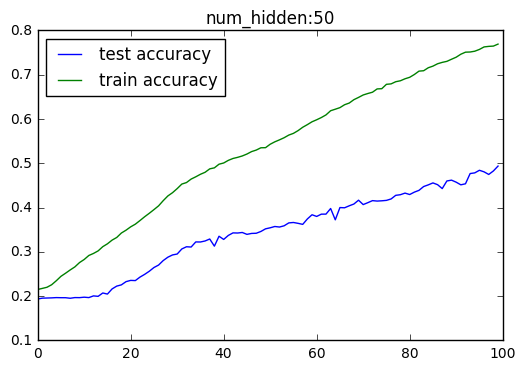

Train max accuracy:0.769
Test max accuracy:0.494


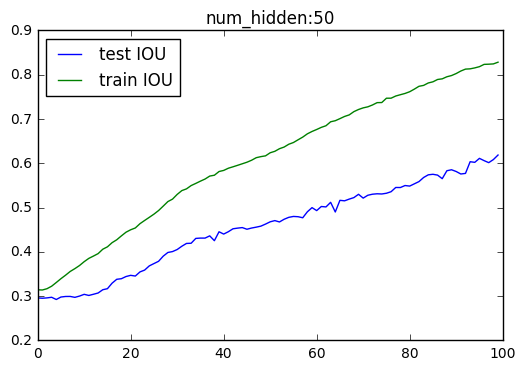

Train max IOU:0.828
Test max IOU:0.619


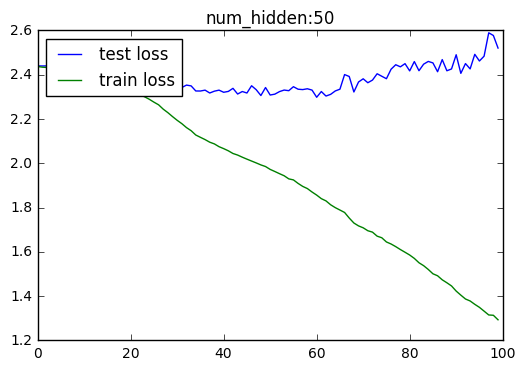

Train min loss:1.293
Test min loss:2.298
---------------------------------------------------------------------------------------------------- 

num_hidden: 100


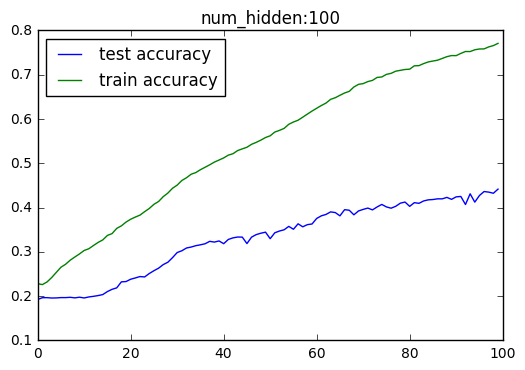

Train max accuracy:0.771
Test max accuracy:0.442


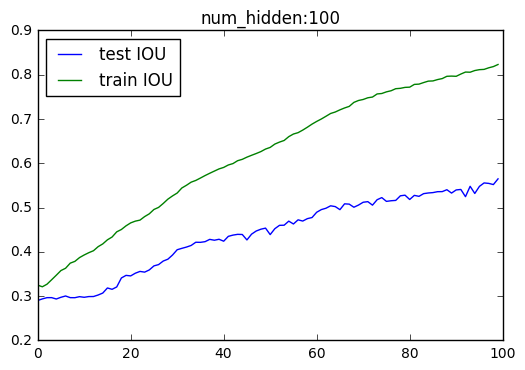

Train max IOU:0.823
Test max IOU:0.565


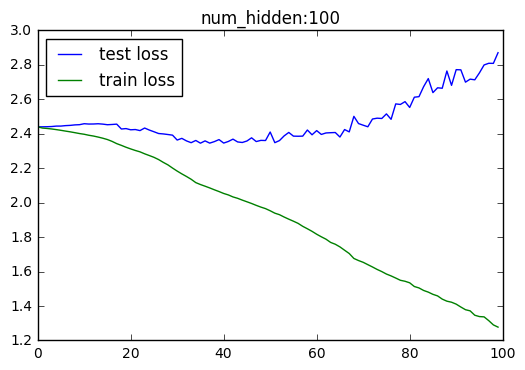

Train min loss:1.277
Test min loss:2.345
---------------------------------------------------------------------------------------------------- 

num_hidden: 150


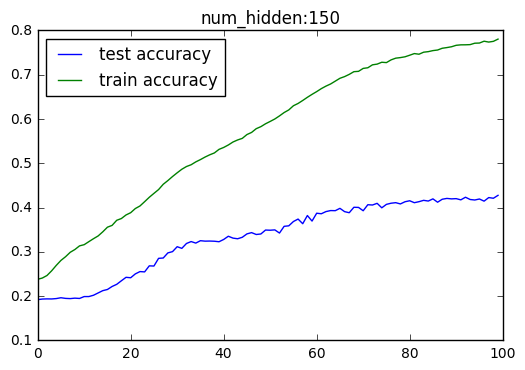

Train max accuracy:0.780
Test max accuracy:0.428


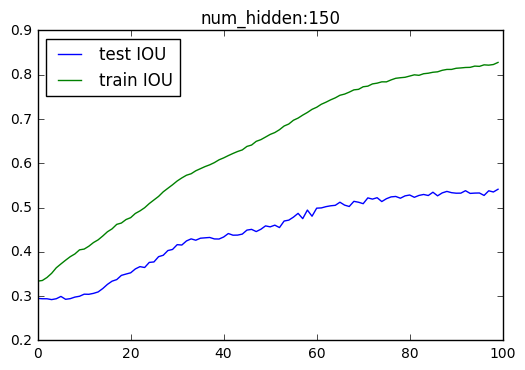

Train max IOU:0.828
Test max IOU:0.541


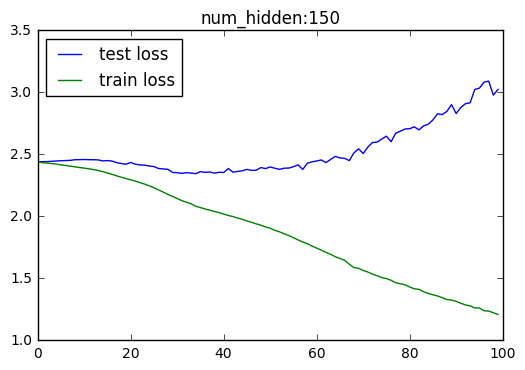

Train min loss:1.210
Test min loss:2.345
---------------------------------------------------------------------------------------------------- 

num_hidden: 200


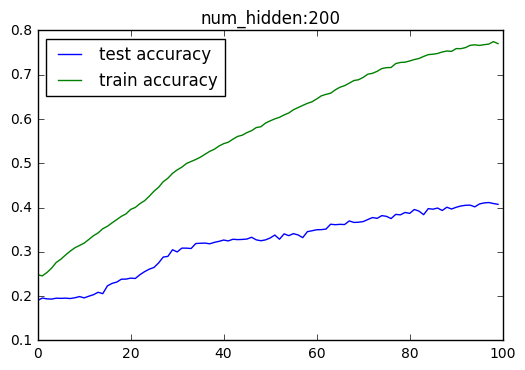

Train max accuracy:0.775
Test max accuracy:0.411


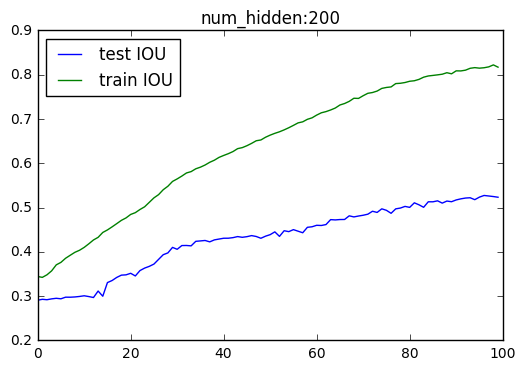

Train max IOU:0.822
Test max IOU:0.527


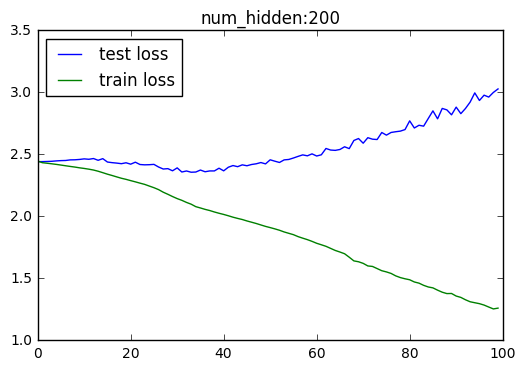

Train min loss:1.254
Test min loss:2.357
---------------------------------------------------------------------------------------------------- 



In [74]:
stats(test_res, train_res)

# Grounder with bi-directional RNN

In [ ]:
# Base with bidirectional rnn
bi_test_res, bi_train_res = [], []

for num_hidden in [50, 100, 150, 200]:
    params_dir = params_dir_tmp+'base/Bi_hidden:'+str(num_hidden)
    tf.reset_default_graph()
    m = Model(
        batch_size=200, 
        num_hidden=num_hidden,
        embed_size=embed_vecs.shape[1],
        img_dims=trainset[0][0][1][0].shape[1], 
        bbox_dims=trainset[0][0][1][1].shape[1], 
        lr=.05,
        vocab=vocab, 
        decay_steps=10000, 
        decay_rate=0.9, 
        edit_reward=0.,
        rnn_editProb=0.,
        coefAlr=1,
        useBidirectionalRnn=True,
        bnorm=False
    )


    # start comp
    print('params_dir:', params_dir)
    print('num_hidden:', m.num_hidden)
    print('learning rate:', m.lr)
    tst, trn = m.train(trainset, testset,
            ephocs_num=100,
            start_ephoc=0,
            startA=101,
            activation_ephoc=101,
            muteB=0, 
            activateAProb=0,
            max_activateAProb=0,
            editProb=0,
            edit_reward=0)
    
    bi_test_res.append(tst)
    bi_train_res.append(trn)
    print('\n'+'*'*100)
    print('*'*100)
    print('*'*100,'\n')
    
    
np.save(open('../data/training/results/bi_test_res.bin', 'wb'), bi_test_res)
np.save(open('../data/training/results/bi_test_res.bin', 'wb'), bi_test_res)

params_dir: ../data/training/models/All/base/Bi_hidden:50
num_hidden: 50
learning rate: 0.05
# Train set size: 297
# Training batches: 297
# Test set size: 297
# Testing batches: 297
Initializing variables
Train, ephoc: 0 ; Training B: True
Edit: False ;A: False ;batch: 0 ;gs: 1 ;lr: 0.0500 ;B loss: 1.845 ;acc: 0.360 ;iou: 0.485 ;time: 0:00:01
Edit: False ;A: False ;batch: 50 ;gs: 51 ;lr: 0.0500 ;B loss: 1.910 ;acc: 0.310 ;iou: 0.370 ;time: 0:00:06
Edit: False ;A: False ;batch: 100 ;gs: 101 ;lr: 0.0500 ;B loss: 3.016 ;acc: 0.095 ;iou: 0.195 ;time: 0:00:13
Edit: False ;A: False ;batch: 150 ;gs: 151 ;lr: 0.0500 ;B loss: 3.329 ;acc: 0.130 ;iou: 0.215 ;time: 0:00:19
Edit: False ;A: False ;batch: 200 ;gs: 201 ;lr: 0.0500 ;B loss: 2.889 ;acc: 0.140 ;iou: 0.265 ;time: 0:00:25
Edit: False ;A: False ;batch: 250 ;gs: 251 ;lr: 0.0500 ;B loss: 1.927 ;acc: 0.285 ;iou: 0.385 ;time: 0:00:31

*Training B: True ;B Train loss: 2.437 ;Train accuracy: 0.218 ;IOU accuracy: 0.314 ;Time: 0:00:36 

Testing, e

In [35]:
# Base with bidirectional rnn and word level attention
biAttn_test_res, biAttn_train_res = [], []

for num_hidden in [50, 100, 150, 200]:
    params_dir = params_dir_tmp+'base/BiAttn_hidden:'+str(num_hidden)
    tf.reset_default_graph()
    m = Model(
        batch_size=200, 
        num_hidden=num_hidden,
        embed_size=embed_vecs.shape[1],
        img_dims=trainset[0][0][1][0].shape[1], 
        bbox_dims=trainset[0][0][1][1].shape[1], 
        lr=.05,
        vocab=vocab, 
        decay_steps=10000, 
        decay_rate=0.99, 
        edit_reward=0.,
        rnn_editProb=0.,
        coefAlr=1,
        useBidirectionalRnn=True,
        bnorm=False,
        use_wordAttn=True
    )


    # start comp
    print('params_dir:', params_dir)
    print('num_hidden:', m.num_hidden)
    print('learning rate:', m.lr)
    tst, trn = m.train(trainset, testset,
            ephocs_num=100,
            start_ephoc=0,
            startA=51,
            activation_ephoc=51,
            muteB=0, 
            activateAProb=0,
            max_activateAProb=0,
            editProb=0,
            edit_reward=0)
    
    biAttn_test_res.append(tst)
    biAttn_train_res.append(trn)
    print('\n'+'*'*100)
    print('*'*100)
    print('*'*100,'\n')

params_dir: ../data/training/models/All/base/BiAttn_hidden:50
num_hidden: 50
learning rate: 0.05
# Train set size: 59449
# Training batches: 297
# Test set size: 59507
# Testing batches: 297
Initializing variables
Train, ephoc: 0 ; Training B: True
Edit: False ;A: False ;batch: 0 ;gs: 1 ;lr: 0.0500 ;B loss: 2.487 ;acc: 0.215 ;iou: 0.310 ;time: 0:00:01


KeyboardInterrupt: 

# Batch Normalization
<p>Here we use one directional RNN and no words level attention.<br>
We use batch normalization to both the images and the RNN's final outputs before the final attention layer. Again, we test for the same hidden units sizes and we run for 50 ephocs.</p>

<p> Here the test set IOU is gtes up to 79.9% while the train set IOU gets to 100% in all tests.</p>

In [12]:
# Base model with batch normailzation

bnorm_test_res, bnorm_train_res = [], []

for num_hidden in [50, 100, 150, 200]:
    params_dir = params_dir_tmp+'bnorm_base/hidden:'+str(num_hidden)
    tf.reset_default_graph()
    m = Model(
        batch_size=200, 
        num_hidden=num_hidden,
        embed_size=nembed_vecs.shape[1],,
        img_dims=trainset[0][0][1][0].shape[1], 
        bbox_dims=trainset[0][0][1][1].shape[1], 
        lr=.05,
        vocab=vocab, 
        decay_steps=10000, 
        decay_rate=0.99, 
        edit_reward=0.,
        rnn_editProb=0.,
        coefAlr=1,
        bnorm=True)


    # start comp
    print('params_dir:', params_dir)
    print('num_hidden:', m.num_hidden)
    print('learning rate:', m.lr)
    tst, trn = m.train(trainset, testset,
            ephocs_num=50,
            start_ephoc=0,
            startA=51,
            activation_ephoc=51,
            muteB=0, 
            activateAProb=0,
            max_activateAProb=0,
            editProb=0,
            edit_reward=0)
    
    bnorm_test_res.append(tst)
    bnorm_train_res.append(trn)
    print('\n'+'*'*100)
    print('*'*100)
    print('*'*100,'\n')

params_dir: ../data/training/models/RGAB5/All/bnorm_base/hidden:50
num_hidden: 50
learning rate: 0.05
# Train set size: 59449
# Training batches: 297
# Test set size: 59507
# Testing batches: 297
Initializing variables
Train, ephoc: 0 ; Training B: True
Edit: False ;A: False ;batch: 0 ;gs: 1 ;lr: 0.0500 ;B loss: 2.759 ;acc: 0.325 ;iou: 0.395 ;time: 0:00:00
Edit: False ;A: False ;batch: 50 ;gs: 51 ;lr: 0.0500 ;B loss: 2.695 ;acc: 0.240 ;iou: 0.375 ;time: 0:00:08
Edit: False ;A: False ;batch: 100 ;gs: 101 ;lr: 0.0500 ;B loss: 2.664 ;acc: 0.285 ;iou: 0.405 ;time: 0:00:16
Edit: False ;A: False ;batch: 150 ;gs: 151 ;lr: 0.0500 ;B loss: 2.671 ;acc: 0.320 ;iou: 0.435 ;time: 0:00:25
Edit: False ;A: False ;batch: 200 ;gs: 201 ;lr: 0.0500 ;B loss: 2.539 ;acc: 0.380 ;iou: 0.455 ;time: 0:00:34
Edit: False ;A: False ;batch: 250 ;gs: 251 ;lr: 0.0500 ;B loss: 2.474 ;acc: 0.400 ;iou: 0.470 ;time: 0:00:43

*Training B: True ;B Train loss: 2.625 ;Train accuracy: 0.319 ;IOU accuracy: 0.419 ;Time: 0:00:51

# Dropout

<p> We test the model (with batch normalization) for different numbers of hidden units and dropout ratio. We test dropout for the RNN's input, outputs and both.</p>
<p> While there is no significant improvement (79.9% test IOU for dropout_in=0.5, dropout_out=1), it is interesting to see that here it is clear that the test IOU gets bigger as the number of hudden unit gets bigger. This indicates that dropout is crucial for investigating the model's parameters number.</p> 
<ul>
<li>For dropout_in=0.5, dropout_out=1 we get 78.5, 79.4, 79.7, 79.9<\li>
<li>For dropout_in=1, dropout_out=0.5 we get 79.1, 79.3, 79.6, 79.7<\li>
<li>For dropout_in=0.5, dropout_out=0.5 we get 79.2, 79.3, 79.3, 79.6<\li>

In [17]:
#dropout_in : dropout ratio for the RNN's inputs
#dropout_out : dropout ratio for the RNN's outputs

dout_bnorm_test_res, dout_bnorm_train_res = [], []
drpos_ratio = [[0.5, 1.], [1., 0.5], [.5,.5]]
for num_hidden in [50, 100, 150, 200]:
    for drops in drpos_ratio:
        dropout_in, dropout_out = drops
        params_dir = params_dir_tmp+'bnorm_base/drop_'+str(dropout_in)+','+str(dropout_out)+'_hidden:'+str(num_hidden)
        tf.reset_default_graph()
        m = Model(
            batch_size=200, 
            num_hidden=num_hidden,
            embed_size=embed_vecs.shape[1],,
            img_dims=trainset[0][0][1][0].shape[1], 
            bbox_dims=trainset[0][0][1][1].shape[1], 
            lr=.05,
            vocab=vocab, 
            decay_steps=10000, 
            decay_rate=0.99, 
            edit_reward=0.,
            rnn_editProb=0.,
            coefAlr=1,
            bnorm=True)


        # start comp
        print('dropout_in', dropout_in)
        print('dropout_out', dropout_out)
        print('params_dir:', params_dir)
        print('num_hidden:', m.num_hidden)
        print('learning rate:', m.lr)
        tst, trn = m.train(trainset, testset,
                ephocs_num=50,
                start_ephoc=0,
                startA=51,
                activation_ephoc=51,
                muteB=0, 
                activateAProb=0,
                max_activateAProb=0,
                editProb=0,
                edit_reward=0,
                dropout_in=dropout_in,
                dropout_out=dropout_out)

        dout_bnorm_test_res.append(tst)
        dout_bnorm_train_res.append(trn)
        print('\n'+'*'*100)
        print('*'*100)
        print('*'*100,'\n')

dropout_in 0.5
dropout_out 1.0
params_dir: ../data/training/models/RGAB5/All/bnorm_base/drop_0.5,1.0_hidden:50
num_hidden: 50
learning rate: 0.05
# Train set size: 59449
# Training batches: 297
# Test set size: 59507
# Testing batches: 297
Initializing variables
Train, ephoc: 0 ; Training B: True
Edit: False ;A: False ;batch: 0 ;gs: 1 ;lr: 0.0500 ;B loss: 2.942 ;acc: 0.315 ;iou: 0.380 ;time: 0:00:00
Edit: False ;A: False ;batch: 50 ;gs: 51 ;lr: 0.0500 ;B loss: 2.743 ;acc: 0.235 ;iou: 0.345 ;time: 0:00:09
Edit: False ;A: False ;batch: 100 ;gs: 101 ;lr: 0.0500 ;B loss: 2.614 ;acc: 0.300 ;iou: 0.445 ;time: 0:00:18
Edit: False ;A: False ;batch: 150 ;gs: 151 ;lr: 0.0500 ;B loss: 2.658 ;acc: 0.320 ;iou: 0.435 ;time: 0:00:28
Edit: False ;A: False ;batch: 200 ;gs: 201 ;lr: 0.0500 ;B loss: 2.693 ;acc: 0.310 ;iou: 0.425 ;time: 0:00:37
Edit: False ;A: False ;batch: 250 ;gs: 251 ;lr: 0.0500 ;B loss: 2.491 ;acc: 0.310 ;iou: 0.475 ;time: 0:00:47

*Training B: True ;B Train loss: 2.639 ;Train accurac

### Image Dropout

<p>Next we use 200 hidden units and we add dropout ratio of 0.5 to the images vectors before the final attention layer<br>
We test it for different dropout_in and dropout_out (as in the privious notebook's cell) </p>

<p><b> This gives us IOU of 82.1% for dropout_in=0.5 (with dropout_out=0.5/1.)</b><br>
We went from 60% IOU to 82.1% just by using regularization. Usually, if a paper writes about the regularization methods at all, it's just writen as a side note, this indicates that for this problam, a good regularization methods is crucial for the research and it need to be taken into account while designing the model and not just as a tuning method or else we might get misleading results.  </p>

In [8]:
# dropout_in +  dropout_out + drop_img
dimg_bnorm_test_res, dimg_bnorm_train_res = [], []
num_hidden=200
drpos_ratio = [[0.5, 1.], [1., 0.5], [.5,.5]]
for drops in drpos_ratio:
    dropout_in, dropout_out = drops
    params_dir = params_dir_tmp+'bnorm_base/img_drop_'+str(dropout_in)+','+str(dropout_out)+'_hidden:'+str(num_hidden)
    tf.reset_default_graph()
    m = Model(
        batch_size=200, 
        num_hidden=num_hidden,
        embed_size=embed_vecs.shape[1],,
        img_dims=trainset[0][0][1][0].shape[1], 
        bbox_dims=trainset[0][0][1][1].shape[1], 
        lr=.05,
        vocab=vocab, 
        decay_steps=10000, 
        decay_rate=0.99, 
        edit_reward=0.,
        rnn_editProb=0.,
        coefAlr=1,
        bnorm=True)


    # start comp
    print('dropout_in', dropout_in)
    print('dropout_out', dropout_out)
    print('params_dir:', params_dir)
    print('num_hidden:', m.num_hidden)
    print('learning rate:', m.lr)
    tst, trn = m.train(trainset, testset,
            ephocs_num=70,
            start_ephoc=0,
            startA=71,
            activation_ephoc=71,
            muteB=0, 
            activateAProb=0,
            max_activateAProb=0,
            editProb=0,
            edit_reward=0,
            dropout_img=0.5,
            dropout_in=dropout_in,
            dropout_out=dropout_out)

    dimg_bnorm_test_res.append(tst)
    dimg_bnorm_train_res.append(trn)
    print('\n'+'*'*100)
    print('*'*100)
    print('*'*100,'\n')                                                             

dropout_in 0.5
dropout_out 1.0
params_dir: ../data/training/models/RGAB5/All/bnorm_base/img_drop_0.5,1.0_hidden:200
num_hidden: 200
learning rate: 0.05
# Train set size: 59449
# Training batches: 297
# Test set size: 59507
# Testing batches: 297
Initializing variables
Train, ephoc: 0 ; Training B: True
Edit: False ;A: False ;batch: 0 ;gs: 1 ;lr: 0.0500 ;B loss: 2.971 ;acc: 0.315 ;iou: 0.400 ;time: 0:00:01
Edit: False ;A: False ;batch: 50 ;gs: 51 ;lr: 0.0500 ;B loss: 2.728 ;acc: 0.230 ;iou: 0.330 ;time: 0:00:11
Edit: False ;A: False ;batch: 100 ;gs: 101 ;lr: 0.0500 ;B loss: 2.845 ;acc: 0.250 ;iou: 0.330 ;time: 0:00:19
Edit: False ;A: False ;batch: 150 ;gs: 151 ;lr: 0.0500 ;B loss: 2.726 ;acc: 0.280 ;iou: 0.400 ;time: 0:00:29
Edit: False ;A: False ;batch: 200 ;gs: 201 ;lr: 0.0500 ;B loss: 2.560 ;acc: 0.360 ;iou: 0.440 ;time: 0:00:38
Edit: False ;A: False ;batch: 250 ;gs: 251 ;lr: 0.0500 ;B loss: 2.666 ;acc: 0.280 ;iou: 0.370 ;time: 0:00:47

*Training B: True ;B Train loss: 2.690 ;Train a

# Augmenting data
<p>This is a mass </p>
<p>Didn't really arange it proparly yet but you can see the results.</p>
<p>The overfitting actually gets worse some how. The only difference is that the probability for the true bbox gets smaller so we get high IOU even for relative high loss.<br>
Interestly, at some point I stoped the training on the Augmented data and start over again with the normal size data. We still have overfitting and the training IOU gets smaller while the testing IOU gets stucked, but the thing is that now the training learning rate gets smaller, i.e. we can see the loss gets smaller but in a very slow rate.</p>

<p>Any way, might be a stupid idea</p>

In [10]:
# Augmenting data
# The accuracy and IOU of the trainin set includs data points 
# with no true groinding bbox so the true training's accuracy and IOU
# is higher then we can see in the reults here (TODO: fix it)

print(len(trainset))
augment_data(trainset)
print(len(trainset))


aug_bnorm_test_res, aug_bnorm_train_res = [], []
num_hidden = 200
dropout_in=0.5
dropout_out=1.
dropout_img = 0.5
params_dir = params_dir_tmp+'bnorm_base/augmented_'+str(dropout_in)+','+str(dropout_out)+','+str(dropout_img)+'_hidden:'+str(num_hidden)

tf.reset_default_graph()
m = Model(
    batch_size=200, 
    num_hidden=num_hidden,
    embed_size=num_hidden,
    img_dims=trainset[0][0][1][0].shape[1], 
    bbox_dims=trainset[0][0][1][1].shape[1], 
    lr=.05,
    vocab=vocab, 
    decay_steps=10000, 
    decay_rate=0.99, 
    edit_reward=0.,
    rnn_editProb=0.,
    coefAlr=1,
    bnorm=True)


# start comp
print('params_dir:', params_dir)
print('num_hidden:', m.num_hidden)
print('learning rate:', m.lr)
tst, trn = m.train(trainset, testset,
        ephocs_num=70,
        start_ephoc=0,
        startA=101,
        activation_ephoc=101,
        muteB=0, 
        activateAProb=0,
        max_activateAProb=0,
        editProb=0,
        edit_reward=0,
        dropout_img=dropout_img,
        dropout_in=dropout_in,
        dropout_out=dropout_out)

aug_bnorm_test_res.append(tst)
aug_bnorm_train_res.append(trn)
print('\n'+'*'*100)
print('*'*100)
print('*'*100,'\n')

59449
89173
params_dir: ../data/training/models/RGAB5/All/bnorm_base/augmented_0.5,1.0,0.5_hidden:200
num_hidden: 200
learning rate: 0.05
# Train set size: 89173
# Training batches: 445
# Test set size: 59507
# Testing batches: 297
Initializing variables
Train, ephoc: 0 ; Training B: True
Edit: False ;A: False ;batch: 0 ;gs: 1 ;lr: 0.0500 ;B loss: 3.035 ;acc: 0.250 ;iou: 0.365 ;time: 0:00:00
Edit: False ;A: False ;batch: 50 ;gs: 51 ;lr: 0.0500 ;B loss: 2.473 ;acc: 0.225 ;iou: 0.350 ;time: 0:00:09
Edit: False ;A: False ;batch: 100 ;gs: 101 ;lr: 0.0500 ;B loss: 2.480 ;acc: 0.220 ;iou: 0.325 ;time: 0:00:17
Edit: False ;A: False ;batch: 150 ;gs: 151 ;lr: 0.0500 ;B loss: 2.445 ;acc: 0.190 ;iou: 0.295 ;time: 0:00:26
Edit: False ;A: False ;batch: 200 ;gs: 201 ;lr: 0.0500 ;B loss: 2.514 ;acc: 0.170 ;iou: 0.295 ;time: 0:00:35
Edit: False ;A: False ;batch: 250 ;gs: 251 ;lr: 0.0500 ;B loss: 2.591 ;acc: 0.180 ;iou: 0.280 ;time: 0:00:44
Edit: False ;A: False ;batch: 300 ;gs: 301 ;lr: 0.0500 ;B loss

KeyboardInterrupt: 

In [11]:
# Augmenting data
# The accuracy and IOU of the trainin set includs data points 
# with no true groinding bbox so the true training's accuracy and IOU
# is higher then we can see in the reults here (TODO: fix it)
# increasing learning rate

num_hidden = 200
dropout_in=0.5
dropout_out=1.
dropout_img = 0.5
params_dir = params_dir_tmp+'bnorm_base/augmented_'+str(dropout_in)+','+str(dropout_out)+','+str(dropout_img)+'_hidden:'+str(num_hidden)

tf.reset_default_graph()
m = Model(
    batch_size=200, 
    num_hidden=num_hidden,
    embed_size=num_hidden,
    img_dims=trainset[0][0][1][0].shape[1], 
    bbox_dims=trainset[0][0][1][1].shape[1], 
    lr=.1,
    vocab=vocab, 
    decay_steps=10000, 
    decay_rate=0.99, 
    edit_reward=0.,
    rnn_editProb=0.,
    coefAlr=1,
    bnorm=True)


# start comp
print('params_dir:', params_dir)
print('num_hidden:', m.num_hidden)
print('learning rate:', m.lr)
tst, trn = m.train(trainset, testset,
        ephocs_num=100,
        start_ephoc=18,
        startA=101,
        activation_ephoc=101,
        muteB=0, 
        activateAProb=0,
        max_activateAProb=0,
        editProb=0,
        edit_reward=0,
        dropout_img=dropout_img,
        dropout_in=dropout_in,
        dropout_out=dropout_out)

aug_bnorm_test_res.append(tst)
aug_bnorm_train_res.append(trn)
print('\n'+'*'*100)
print('*'*100)
print('*'*100,'\n')

params_dir: ../data/training/models/RGAB5/All/bnorm_base/augmented_0.5,1.0,0.5_hidden:200
num_hidden: 200
learning rate: 0.1
# Train set size: 89173
# Training batches: 445
# Test set size: 59507
# Testing batches: 297
Loading parameters from ../data/training/models/RGAB5/All/bnorm_base/augmented_0.5,1.0,0.5_hidden:200/model.ckpt-17
INFO:tensorflow:Restoring parameters from ../data/training/models/RGAB5/All/bnorm_base/augmented_0.5,1.0,0.5_hidden:200/model.ckpt-17
Train, ephoc: 18 ; Training B: True
Edit: False ;A: False ;batch: 0 ;gs: 8011 ;lr: 0.1000 ;B loss: 2.345 ;acc: 0.475 ;iou: 0.575 ;time: 0:00:01
Edit: False ;A: False ;batch: 50 ;gs: 8061 ;lr: 0.1000 ;B loss: 2.349 ;acc: 0.450 ;iou: 0.525 ;time: 0:00:14
Edit: False ;A: False ;batch: 100 ;gs: 8111 ;lr: 0.1000 ;B loss: 2.446 ;acc: 0.415 ;iou: 0.525 ;time: 0:00:26
Edit: False ;A: False ;batch: 150 ;gs: 8161 ;lr: 0.1000 ;B loss: 2.259 ;acc: 0.475 ;iou: 0.560 ;time: 0:00:39
Edit: False ;A: False ;batch: 200 ;gs: 8211 ;lr: 0.1000 ;B

KeyboardInterrupt: 

In [12]:
# Augmenting data
# The accuracy and IOU of the trainin set includs data points 
# with no true groinding bbox so the true training's accuracy and IOU
# is higher then we can see in the reults here (TODO: fix it)
# increasing learning rate even more

num_hidden = 200
dropout_in=0.5
dropout_out=1.
dropout_img = 0.5
params_dir = params_dir_tmp+'bnorm_base/augmented_'+str(dropout_in)+','+str(dropout_out)+','+str(dropout_img)+'_hidden:'+str(num_hidden)

tf.reset_default_graph()
m = Model(
    batch_size=200, 
    num_hidden=num_hidden,
    embed_size=num_hidden,
    img_dims=trainset[0][1][0].shape[1], 
    bbox_dims=trainset[0][1][1].shape[1], 
    lr=.2,
    vocab=vocab, 
    decay_steps=10000, 
    decay_rate=0.99, 
    edit_reward=0.,
    rnn_editProb=0.,
    coefAlr=1,
    bnorm=True)


# start comp
print('params_dir:', params_dir)
print('num_hidden:', m.num_hidden)
print('learning rate:', m.lr)
tst, trn = m.train(trainset, testset,
        ephocs_num=100,
        start_ephoc=21,
        startA=101,
        activation_ephoc=101,
        muteB=0, 
        activateAProb=0,
        max_activateAProb=0,
        editProb=0,
        edit_reward=0,
        dropout_img=dropout_img,
        dropout_in=dropout_in,
        dropout_out=dropout_out)

aug_bnorm_test_res.append(tst)
aug_bnorm_train_res.append(trn)
print('\n'+'*'*100)
print('*'*100)
print('*'*100,'\n')

params_dir: ../data/training/models/RGAB5/All/bnorm_base/augmented_0.5,1.0,0.5_hidden:200
num_hidden: 200
learning rate: 0.2
# Train set size: 89173
# Training batches: 445
# Test set size: 59507
# Testing batches: 297
Loading parameters from ../data/training/models/RGAB5/All/bnorm_base/augmented_0.5,1.0,0.5_hidden:200/model.ckpt-20
INFO:tensorflow:Restoring parameters from ../data/training/models/RGAB5/All/bnorm_base/augmented_0.5,1.0,0.5_hidden:200/model.ckpt-20
Train, ephoc: 21 ; Training B: True
Edit: False ;A: False ;batch: 0 ;gs: 9346 ;lr: 0.2000 ;B loss: 2.260 ;acc: 0.500 ;iou: 0.570 ;time: 0:00:01
Edit: False ;A: False ;batch: 50 ;gs: 9396 ;lr: 0.2000 ;B loss: 2.262 ;acc: 0.485 ;iou: 0.575 ;time: 0:00:14
Edit: False ;A: False ;batch: 100 ;gs: 9446 ;lr: 0.2000 ;B loss: 2.252 ;acc: 0.470 ;iou: 0.575 ;time: 0:00:28
Edit: False ;A: False ;batch: 150 ;gs: 9496 ;lr: 0.2000 ;B loss: 2.292 ;acc: 0.480 ;iou: 0.565 ;time: 0:00:41
Edit: False ;A: False ;batch: 200 ;gs: 9546 ;lr: 0.2000 ;B

KeyboardInterrupt: 

In [13]:
# Augmenting data
# The accuracy and IOU of the trainin set includs data points 
# with no true groinding bbox so the true training's accuracy and IOU
# is higher then we can see in the reults here (TODO: fix it)
# decreasing learning rate even more

num_hidden = 200
dropout_in=0.5
dropout_out=1.
dropout_img = 0.5
params_dir = params_dir_tmp+'bnorm_base/augmented_'+str(dropout_in)+','+str(dropout_out)+','+str(dropout_img)+'_hidden:'+str(num_hidden)

tf.reset_default_graph()
m = Model(
    batch_size=200, 
    num_hidden=num_hidden,
    embed_size=num_hidden,
    img_dims=trainset[0][1][0].shape[1], 
    bbox_dims=trainset[0][1][1].shape[1], 
    lr=.1,
    vocab=vocab, 
    decay_steps=10000, 
    decay_rate=0.99, 
    edit_reward=0.,
    rnn_editProb=0.,
    coefAlr=1,
    bnorm=True)


# start comp
print('params_dir:', params_dir)
print('num_hidden:', m.num_hidden)
print('learning rate:', m.lr)
tst, trn = m.train(trainset, testset,
        ephocs_num=100,
        start_ephoc=29,
        startA=101,
        activation_ephoc=101,
        muteB=0, 
        activateAProb=0,
        max_activateAProb=0,
        editProb=0,
        edit_reward=0,
        dropout_img=dropout_img,
        dropout_in=dropout_in,
        dropout_out=dropout_out)

aug_bnorm_test_res.append(tst)
aug_bnorm_train_res.append(trn)
print('\n'+'*'*100)
print('*'*100)
print('*'*100,'\n')

params_dir: ../data/training/models/RGAB5/All/bnorm_base/augmented_0.5,1.0,0.5_hidden:200
num_hidden: 200
learning rate: 0.1
# Train set size: 89173
# Training batches: 445
# Test set size: 59507
# Testing batches: 297
Loading parameters from ../data/training/models/RGAB5/All/bnorm_base/augmented_0.5,1.0,0.5_hidden:200/model.ckpt-28
INFO:tensorflow:Restoring parameters from ../data/training/models/RGAB5/All/bnorm_base/augmented_0.5,1.0,0.5_hidden:200/model.ckpt-28
Train, ephoc: 29 ; Training B: True
Edit: False ;A: False ;batch: 0 ;gs: 12906 ;lr: 0.0990 ;B loss: 2.098 ;acc: 0.525 ;iou: 0.645 ;time: 0:00:01
Edit: False ;A: False ;batch: 50 ;gs: 12956 ;lr: 0.0990 ;B loss: 2.029 ;acc: 0.600 ;iou: 0.690 ;time: 0:00:18
Edit: False ;A: False ;batch: 100 ;gs: 13006 ;lr: 0.0990 ;B loss: 2.156 ;acc: 0.585 ;iou: 0.635 ;time: 0:00:34
Edit: False ;A: False ;batch: 150 ;gs: 13056 ;lr: 0.0990 ;B loss: 2.068 ;acc: 0.555 ;iou: 0.615 ;time: 0:00:50
Edit: False ;A: False ;batch: 200 ;gs: 13106 ;lr: 0.09

KeyboardInterrupt: 

In [14]:
# Augmenting data
# The accuracy and IOU of the trainin set includs data points 
# with no true groinding bbox so the true training's accuracy and IOU
# is higher then we can see in the reults here (TODO: fix it)
# decreasing learning rate even more

num_hidden = 200
dropout_in=0.5
dropout_out=1.
dropout_img = 0.5
params_dir = params_dir_tmp+'bnorm_base/augmented_'+str(dropout_in)+','+str(dropout_out)+','+str(dropout_img)+'_hidden:'+str(num_hidden)

tf.reset_default_graph()
m = Model(
    batch_size=200, 
    num_hidden=num_hidden,
    embed_size=num_hidden,
    img_dims=trainset[0][1][0].shape[1], 
    bbox_dims=trainset[0][1][1].shape[1], 
    lr=.05,
    vocab=vocab, 
    decay_steps=10000, 
    decay_rate=0.99, 
    edit_reward=0.,
    rnn_editProb=0.,
    coefAlr=1,
    bnorm=True)


# start comp
print('params_dir:', params_dir)
print('num_hidden:', m.num_hidden)
print('learning rate:', m.lr)
tst, trn = m.train(trainset, testset,
        ephocs_num=100,
        start_ephoc=32,
        startA=101,
        activation_ephoc=101,
        muteB=0, 
        activateAProb=0,
        max_activateAProb=0,
        editProb=0,
        edit_reward=0,
        dropout_img=dropout_img,
        dropout_in=dropout_in,
        dropout_out=dropout_out)

aug_bnorm_test_res.append(tst)
aug_bnorm_train_res.append(trn)
print('\n'+'*'*100)
print('*'*100)
print('*'*100,'\n')

params_dir: ../data/training/models/RGAB5/All/bnorm_base/augmented_0.5,1.0,0.5_hidden:200
num_hidden: 200
learning rate: 0.05
# Train set size: 89173
# Training batches: 445
# Test set size: 59507
# Testing batches: 297
Loading parameters from ../data/training/models/RGAB5/All/bnorm_base/augmented_0.5,1.0,0.5_hidden:200/model.ckpt-31
INFO:tensorflow:Restoring parameters from ../data/training/models/RGAB5/All/bnorm_base/augmented_0.5,1.0,0.5_hidden:200/model.ckpt-31
Train, ephoc: 32 ; Training B: True
Edit: False ;A: False ;batch: 0 ;gs: 14241 ;lr: 0.0495 ;B loss: 2.237 ;acc: 0.535 ;iou: 0.620 ;time: 0:00:01
Edit: False ;A: False ;batch: 50 ;gs: 14291 ;lr: 0.0495 ;B loss: 2.164 ;acc: 0.560 ;iou: 0.640 ;time: 0:00:16
Edit: False ;A: False ;batch: 100 ;gs: 14341 ;lr: 0.0495 ;B loss: 2.208 ;acc: 0.465 ;iou: 0.560 ;time: 0:00:32
Edit: False ;A: False ;batch: 150 ;gs: 14391 ;lr: 0.0495 ;B loss: 2.006 ;acc: 0.595 ;iou: 0.660 ;time: 0:00:49
Edit: False ;A: False ;batch: 200 ;gs: 14441 ;lr: 0.0

KeyboardInterrupt: 

In [15]:
# Augmenting data
# The accuracy and IOU of the trainin set includs data points 
# with no true groinding bbox so the true training's accuracy and IOU
# is higher then we can see in the reults here (TODO: fix it)
# decreasing learning rate even more

num_hidden = 200
dropout_in=0.5
dropout_out=1.
dropout_img = 0.5
params_dir = params_dir_tmp+'bnorm_base/augmented_'+str(dropout_in)+','+str(dropout_out)+','+str(dropout_img)+'_hidden:'+str(num_hidden)

tf.reset_default_graph()
m = Model(
    batch_size=200, 
    num_hidden=num_hidden,
    embed_size=num_hidden,
    img_dims=trainset[0][1][0].shape[1], 
    bbox_dims=trainset[0][1][1].shape[1], 
    lr=.005,
    vocab=vocab, 
    decay_steps=10000, 
    decay_rate=0.99, 
    edit_reward=0.,
    rnn_editProb=0.,
    coefAlr=1,
    bnorm=True)


# start comp
print('params_dir:', params_dir)
print('num_hidden:', m.num_hidden)
print('learning rate:', m.lr)
tst, trn = m.train(trainset, testset,
        ephocs_num=100,
        start_ephoc=37,
        startA=101,
        activation_ephoc=101,
        muteB=0, 
        activateAProb=0,
        max_activateAProb=0,
        editProb=0,
        edit_reward=0,
        dropout_img=dropout_img,
        dropout_in=dropout_in,
        dropout_out=dropout_out)

aug_bnorm_test_res.append(tst)
aug_bnorm_train_res.append(trn)
print('\n'+'*'*100)
print('*'*100)
print('*'*100,'\n')

params_dir: ../data/training/models/RGAB5/All/bnorm_base/augmented_0.5,1.0,0.5_hidden:200
num_hidden: 200
learning rate: 0.005
# Train set size: 89173
# Training batches: 445
# Test set size: 59507
# Testing batches: 297
Loading parameters from ../data/training/models/RGAB5/All/bnorm_base/augmented_0.5,1.0,0.5_hidden:200/model.ckpt-36
INFO:tensorflow:Restoring parameters from ../data/training/models/RGAB5/All/bnorm_base/augmented_0.5,1.0,0.5_hidden:200/model.ckpt-36
Train, ephoc: 37 ; Training B: True
Edit: False ;A: False ;batch: 0 ;gs: 16466 ;lr: 0.0049 ;B loss: 2.067 ;acc: 0.590 ;iou: 0.685 ;time: 0:00:02
Edit: False ;A: False ;batch: 50 ;gs: 16516 ;lr: 0.0049 ;B loss: 2.090 ;acc: 0.585 ;iou: 0.640 ;time: 0:01:06
Edit: False ;A: False ;batch: 100 ;gs: 16566 ;lr: 0.0049 ;B loss: 2.112 ;acc: 0.595 ;iou: 0.620 ;time: 0:02:23
Edit: False ;A: False ;batch: 150 ;gs: 16616 ;lr: 0.0049 ;B loss: 2.139 ;acc: 0.540 ;iou: 0.630 ;time: 0:03:35
Edit: False ;A: False ;batch: 200 ;gs: 16666 ;lr: 0.

KeyboardInterrupt: 

In [12]:
# Augmenting data
# The accuracy and IOU of the trainin set includs data points 
# with no true groinding bbox so the true training's accuracy and IOU
# is higher then we can see in the reults here (TODO: fix it)
# decreasing learning rate even more

print(len(trainset))
augment_data(trainset)
print(len(trainset))

num_hidden = 200
dropout_in=0.5
dropout_out=1.
dropout_img = 0.5
params_dir = params_dir_tmp+'bnorm_base/augmented_'+str(dropout_in)+','+str(dropout_out)+','+str(dropout_img)+'_hidden:'+str(num_hidden)

tf.reset_default_graph()
m = Model(
    batch_size=200, 
    num_hidden=num_hidden,
    embed_size=num_hidden,
    img_dims=trainset[0][1][0].shape[1], 
    bbox_dims=trainset[0][1][1].shape[1], 
    lr=.05,
    vocab=vocab, 
    decay_steps=10000, 
    decay_rate=0.99, 
    edit_reward=0.,
    rnn_editProb=0.,
    coefAlr=1,
    bnorm=True)


# start comp
print('params_dir:', params_dir)
print('num_hidden:', m.num_hidden)
print('learning rate:', m.lr)
tst, trn = m.train(trainset, testset,
        ephocs_num=100,
        start_ephoc=38,
        startA=101,
        activation_ephoc=101,
        muteB=0, 
        activateAProb=0,
        max_activateAProb=0,
        editProb=0,
        edit_reward=0,
        dropout_img=dropout_img,
        dropout_in=dropout_in,
        dropout_out=dropout_out)

aug_bnorm_test_res.append(tst)
aug_bnorm_train_res.append(trn)
print('\n'+'*'*100)
print('*'*100)
print('*'*100,'\n')

59449
89173
params_dir: ../data/training/models/RGAB5/All/bnorm_base/augmented_0.5,1.0,0.5_hidden:200
num_hidden: 200
learning rate: 0.05
# Train set size: 89173
# Training batches: 445
# Test set size: 59507
# Testing batches: 297
Loading parameters from ../data/training/models/RGAB5/All/bnorm_base/augmented_0.5,1.0,0.5_hidden:200/model.ckpt-37
INFO:tensorflow:Restoring parameters from ../data/training/models/RGAB5/All/bnorm_base/augmented_0.5,1.0,0.5_hidden:200/model.ckpt-37
Train, ephoc: 38 ; Training B: True
Edit: False ;A: False ;batch: 0 ;gs: 16911 ;lr: 0.0495 ;B loss: 2.077 ;acc: 0.565 ;iou: 0.650 ;time: 0:00:00
Edit: False ;A: False ;batch: 50 ;gs: 16961 ;lr: 0.0495 ;B loss: 2.238 ;acc: 0.595 ;iou: 0.665 ;time: 0:00:10
Edit: False ;A: False ;batch: 100 ;gs: 17011 ;lr: 0.0495 ;B loss: 2.048 ;acc: 0.580 ;iou: 0.650 ;time: 0:00:20
Edit: False ;A: False ;batch: 150 ;gs: 17061 ;lr: 0.0495 ;B loss: 2.077 ;acc: 0.535 ;iou: 0.625 ;time: 0:00:31
Edit: False ;A: False ;batch: 200 ;gs: 17

KeyboardInterrupt: 

<p>This is where remove the artificially added points</p>

In [15]:
trainset = np.load(open(trainset_file, 'rb'))
trainset = [item for item in trainset if len(item)>2 and len(item[0])>0]
print('trainset length:', len(trainset))

trainset length: 59449


In [16]:
num_hidden = 200
dropout_in=0.5
dropout_out=1.
dropout_img = 0.5
params_dir = params_dir_tmp+'bnorm_base/augmented_'+str(dropout_in)+','+str(dropout_out)+','+str(dropout_img)+'_hidden:'+str(num_hidden)

tf.reset_default_graph()
m = Model(
    batch_size=200, 
    num_hidden=num_hidden,
    embed_size=num_hidden,
    img_dims=trainset[0][1][0].shape[1], 
    bbox_dims=trainset[0][1][1].shape[1], 
    lr=.05,
    vocab=vocab, 
    decay_steps=10000, 
    decay_rate=0.99, 
    edit_reward=0.,
    rnn_editProb=0.,
    coefAlr=1,
    bnorm=True)


# start comp
print('params_dir:', params_dir)
print('num_hidden:', m.num_hidden)
print('learning rate:', m.lr)
tst, trn = m.train(trainset, testset,
        ephocs_num=100,
        start_ephoc=50,
        startA=101,
        activation_ephoc=101,
        muteB=0, 
        activateAProb=0,
        max_activateAProb=0,
        editProb=0,
        edit_reward=0,
        dropout_img=dropout_img,
        dropout_in=dropout_in,
        dropout_out=dropout_out)

aug_bnorm_test_res.append(tst)
aug_bnorm_train_res.append(trn)
print('\n'+'*'*100)
print('*'*100)
print('*'*100,'\n')

params_dir: ../data/training/models/RGAB5/All/bnorm_base/augmented_0.5,1.0,0.5_hidden:200
num_hidden: 200
learning rate: 0.05
# Train set size: 59449
# Training batches: 297
# Test set size: 59507
# Testing batches: 297
Loading parameters from ../data/training/models/RGAB5/All/bnorm_base/augmented_0.5,1.0,0.5_hidden:200/model.ckpt-49
INFO:tensorflow:Restoring parameters from ../data/training/models/RGAB5/All/bnorm_base/augmented_0.5,1.0,0.5_hidden:200/model.ckpt-49
Train, ephoc: 50 ; Training B: True
Edit: False ;A: False ;batch: 0 ;gs: 22251 ;lr: 0.0490 ;B loss: 1.572 ;acc: 0.790 ;iou: 0.865 ;time: 0:00:00
Edit: False ;A: False ;batch: 50 ;gs: 22301 ;lr: 0.0490 ;B loss: 1.603 ;acc: 0.815 ;iou: 0.895 ;time: 0:00:15
Edit: False ;A: False ;batch: 100 ;gs: 22351 ;lr: 0.0490 ;B loss: 1.410 ;acc: 0.820 ;iou: 0.890 ;time: 0:00:29
Edit: False ;A: False ;batch: 150 ;gs: 22401 ;lr: 0.0490 ;B loss: 1.638 ;acc: 0.800 ;iou: 0.880 ;time: 0:00:43
Edit: False ;A: False ;batch: 200 ;gs: 22451 ;lr: 0.0

KeyboardInterrupt: 

In [11]:
# Augmenting data
# The accuracy and IOU of the trainin set includs data points 
# with no true groinding bbox so the true training's accuracy and IOU
# is higher then we can see in the reults here (TODO: fix it)
# decreasing learning rate even more

print(len(trainset))
augment_data(trainset, ratio=0.6)
print(len(trainset))

num_hidden = 200
dropout_in=0.5
dropout_out=1.
dropout_img = 0.5
params_dir = params_dir_tmp+'bnorm_base/augmented_'+str(dropout_in)+','+str(dropout_out)+','+str(dropout_img)+'_hidden:'+str(num_hidden)

tf.reset_default_graph()
m = Model(
    batch_size=200, 
    num_hidden=num_hidden,
    embed_size=num_hidden,
    img_dims=trainset[0][1][0].shape[1], 
    bbox_dims=trainset[0][1][1].shape[1], 
    lr=.05,
    vocab=vocab, 
    decay_steps=10000, 
    decay_rate=0.99, 
    edit_reward=0.,
    rnn_editProb=0.,
    coefAlr=1,
    bnorm=True)


# start comp
print('params_dir:', params_dir)
print('num_hidden:', m.num_hidden)
print('learning rate:', m.lr)
tst, trn = m.train(trainset, testset,
        ephocs_num=100,
        start_ephoc=63,
        startA=101,
        activation_ephoc=101,
        muteB=0, 
        activateAProb=0,
        max_activateAProb=0,
        editProb=0,
        edit_reward=0,
        dropout_img=dropout_img,
        dropout_in=dropout_in,
        dropout_out=dropout_out)

aug_bnorm_test_res.append(tst)
aug_bnorm_train_res.append(trn)
print('\n'+'*'*100)
print('*'*100)
print('*'*100,'\n')

59449
95118
params_dir: ../data/training/models/RGAB5/All/bnorm_base/augmented_0.5,1.0,0.5_hidden:200
num_hidden: 200
learning rate: 0.05
# Train set size: 95118
# Training batches: 475
# Test set size: 59507
# Testing batches: 297
Loading parameters from ../data/training/models/RGAB5/All/bnorm_base/augmented_0.5,1.0,0.5_hidden:200/model.ckpt-62
INFO:tensorflow:Restoring parameters from ../data/training/models/RGAB5/All/bnorm_base/augmented_0.5,1.0,0.5_hidden:200/model.ckpt-62
Train, ephoc: 63 ; Training B: True
Edit: False ;A: False ;batch: 0 ;gs: 26112 ;lr: 0.0490 ;B loss: 2.353 ;acc: 0.590 ;iou: 0.680 ;time: 0:00:00
Edit: False ;A: False ;batch: 50 ;gs: 26162 ;lr: 0.0490 ;B loss: 2.266 ;acc: 0.590 ;iou: 0.685 ;time: 0:00:14
Edit: False ;A: False ;batch: 100 ;gs: 26212 ;lr: 0.0490 ;B loss: 2.173 ;acc: 0.600 ;iou: 0.650 ;time: 0:00:28
Edit: False ;A: False ;batch: 150 ;gs: 26262 ;lr: 0.0490 ;B loss: 2.133 ;acc: 0.640 ;iou: 0.725 ;time: 0:00:42
Edit: False ;A: False ;batch: 200 ;gs: 26

KeyboardInterrupt: 

In [14]:
trainset = np.load(open(trainset_file, 'rb'))
trainset = [item for item in trainset if len(item)>2 and len(item[0])>0]
print('trainset length:', len(trainset))

trainset length: 59449


In [15]:
# Augmenting data
# The accuracy and IOU of the trainin set includs data points 
# with no true groinding bbox so the true training's accuracy and IOU
# is higher then we can see in the reults here (TODO: fix it)
# decreasing learning rate even more


num_hidden = 200
dropout_in=0.5
dropout_out=1.
dropout_img = 0.5
params_dir = params_dir_tmp+'bnorm_base/augmented_'+str(dropout_in)+','+str(dropout_out)+','+str(dropout_img)+'_hidden:'+str(num_hidden)

tf.reset_default_graph()
m = Model(
    batch_size=200, 
    num_hidden=num_hidden,
    embed_size=num_hidden,
    img_dims=trainset[0][1][0].shape[1], 
    bbox_dims=trainset[0][1][1].shape[1], 
    lr=.05,
    vocab=vocab, 
    decay_steps=10000, 
    decay_rate=0.99, 
    edit_reward=0.,
    rnn_editProb=0.,
    coefAlr=1,
    bnorm=True)


# start comp
print('params_dir:', params_dir)
print('num_hidden:', m.num_hidden)
print('learning rate:', m.lr)
tst, trn = m.train(trainset, testset,
        ephocs_num=200,
        start_ephoc=94,
        startA=101,
        activation_ephoc=101,
        muteB=0, 
        activateAProb=0,
        max_activateAProb=0,
        editProb=0,
        edit_reward=0,
        dropout_img=dropout_img,
        dropout_in=dropout_in,
        dropout_out=dropout_out)

aug_bnorm_test_res.append(tst)
aug_bnorm_train_res.append(trn)
print('\n'+'*'*100)
print('*'*100)
print('*'*100,'\n')

params_dir: ../data/training/models/RGAB5/All/bnorm_base/augmented_0.5,1.0,0.5_hidden:200
num_hidden: 200
learning rate: 0.05
# Train set size: 59449
# Training batches: 297
# Test set size: 59507
# Testing batches: 297
Loading parameters from ../data/training/models/RGAB5/All/bnorm_base/augmented_0.5,1.0,0.5_hidden:200/model.ckpt-93
INFO:tensorflow:Restoring parameters from ../data/training/models/RGAB5/All/bnorm_base/augmented_0.5,1.0,0.5_hidden:200/model.ckpt-93
Train, ephoc: 94 ; Training B: True
Edit: False ;A: False ;batch: 0 ;gs: 40837 ;lr: 0.0480 ;B loss: 1.438 ;acc: 0.865 ;iou: 0.945 ;time: 0:00:00
Edit: False ;A: False ;batch: 50 ;gs: 40887 ;lr: 0.0480 ;B loss: 1.350 ;acc: 0.880 ;iou: 0.915 ;time: 0:00:18
Edit: False ;A: False ;batch: 100 ;gs: 40937 ;lr: 0.0480 ;B loss: 1.292 ;acc: 0.845 ;iou: 0.900 ;time: 0:00:36
Edit: False ;A: False ;batch: 150 ;gs: 40987 ;lr: 0.0480 ;B loss: 1.214 ;acc: 0.875 ;iou: 0.935 ;time: 0:00:55
Edit: False ;A: False ;batch: 200 ;gs: 41037 ;lr: 0.0

KeyboardInterrupt: 